# Exploratory Data Analysis - Part 2

### This notebook is a continuation from the intial exploratory data analysis done in Part 1 to investigate and remove extraneous NA values from the dataset. It looks at the various continuous features that could impact the sales price response. The impacts of categorical features will be examined in Part 3.

Start by importing the data and relevant libraries:

In [1]:
# Load libraries required for data analysis
library(tidyverse)
library(scales)
library(gridExtra)
library(boot)

# Load data (already downloaded and saved locally)
train <- read_csv("train.csv",show_col_types = FALSE)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




Part 1 of the EDA concluded with dropping the NA values in the columns: LotFrontage, Electrical, MasVnrType, MasVnrArea. Let's start by doing that:

In [2]:
train <- train %>% drop_na(LotFrontage, Electrical, MasVnrType, MasVnrArea)

Now check to confirm that these columns no longer contain NA:

In [3]:
NA_columns <- names(train)[sapply(train,anyNA)]
NA_columns

[1] "Alley"        "BsmtQual"     "BsmtCond"     "BsmtExposure" "BsmtFinType1"
 [6] "BsmtFinType2" "FireplaceQu"  "GarageType"   "GarageYrBlt"  "GarageFinish"
[11] "GarageQual"   "GarageCond"   "PoolQC"       "Fence"        "MiscFeature"

Only the columns where NA has a valid corresponding meaning based on the data description remain.

It's time to start visualizing the data. Before proceeding further, first define a few functions that will be useful:

In [4]:
# The column names in the data file are for the most part in shorthand that requires consulting the descriptions associated text file to understand their contents
# Define a switch function to convert the column names in the data file into more human parsable labels
axis_label <- function(column) {
    axis_label <- switch(column,
                      'SalePrice' = 'Sale Price ($)',
                      'LotFrontage' = 'Lot Frontage (ft.)',
                      'LotArea' = 'Lot Area (sq. ft.)',
                      'YearBuilt' = 'Year Built',
                      'YearRemodAdd' = 'Year Remodeled',
                      'GrLivArea' = 'Above Grade Living Area (sq. ft.)',
                      'TotalBsmtSF' = 'Total Basement Area (sq. ft.)',
                      'BsmtFinSF1' = 'Type 1 Finished Basement Area (sq. ft.)',
                      'BsmtFinSF2' = 'Type 2 Finished Basement Area (sq. ft.)',
                      'BsmtUnfSF' = 'Unfinished Basement Area (sq. ft.)',
                      '1stFlrSF' = 'First Floor Area (sq. ft.)',
                      '2ndFlrSF' = 'Second Floor Area (sq. ft.)',
                      'LowQualFinSF' = 'Low Quality Finished Area (sq. ft.)',
                      'TotRmsAbvGrd' = 'Total Rooms Above Grade',
                      'GarageYrBlt' = 'Year Garage Built',
                      'GarageArea' = 'Garage Area (sq. ft.)',
                      'WoodDeckSF' = 'Wood Deck Area (sq. ft.)',
                      'OpenPorchSF' = 'Open Porch Area (sq. ft.)',
                      'EnclosedPorch' = 'Enclosed Porch Area (sq. ft.)',
                      '3SsnPorch' = 'Three Season Porch Area (sq. ft.)',
                      'ScreenPorch' = 'Screened Porch Area (sq. ft.)',
                      'PoolArea' = 'Pool Area (sq.ft.)')
    return(axis_label)
}

In [5]:
# Define a function to plot a histogram
plot_data_column <- function(data, column, bins, width = 20, height = 24) {
    options(repr.plot.width = width, repr.plot.height = height) # adjust to make the plots a reasonable size
    hist_plot <- ggplot(data, aes(!!sym(column))) +
      geom_histogram(bins = bins) + 
      labs(x = axis_label(column)) +
      theme(axis.title = element_text(size = 22),
            axis.text = element_text(size = 18))
    # Make x-axis eas easier to read by adding commas for features with large values
    lrg_val <- c('SalePrice','LotArea','GrLivArea')
    if (column %in% lrg_val) {
        hist_plot_fin <- hist_plot + scale_x_continuous(label = label_comma())
    } else {
        hist_plot_fin <- hist_plot
    }
    return(hist_plot_fin)
}
# Define a function to plot a group of histograms and arrange them in two columns
histogram_plots <- function(hist_data, hist_columns, bins) {
  lapp_columns <- hist_columns
  myplots <- lapply(lapp_columns, plot_data_column, data = train, bins = bins)
  grid.arrange(grobs= lapply(myplots, "+", theme(plot.margin=margin(10,30,10,30))), ncol = 2)
}

Now that we have some functions defined for visualization, let's start by looking at distributions of the response variable (Sale Price) as wells as several continuous variables that based on intuition may influence the response (lot size & frontage as well as age & size of house):

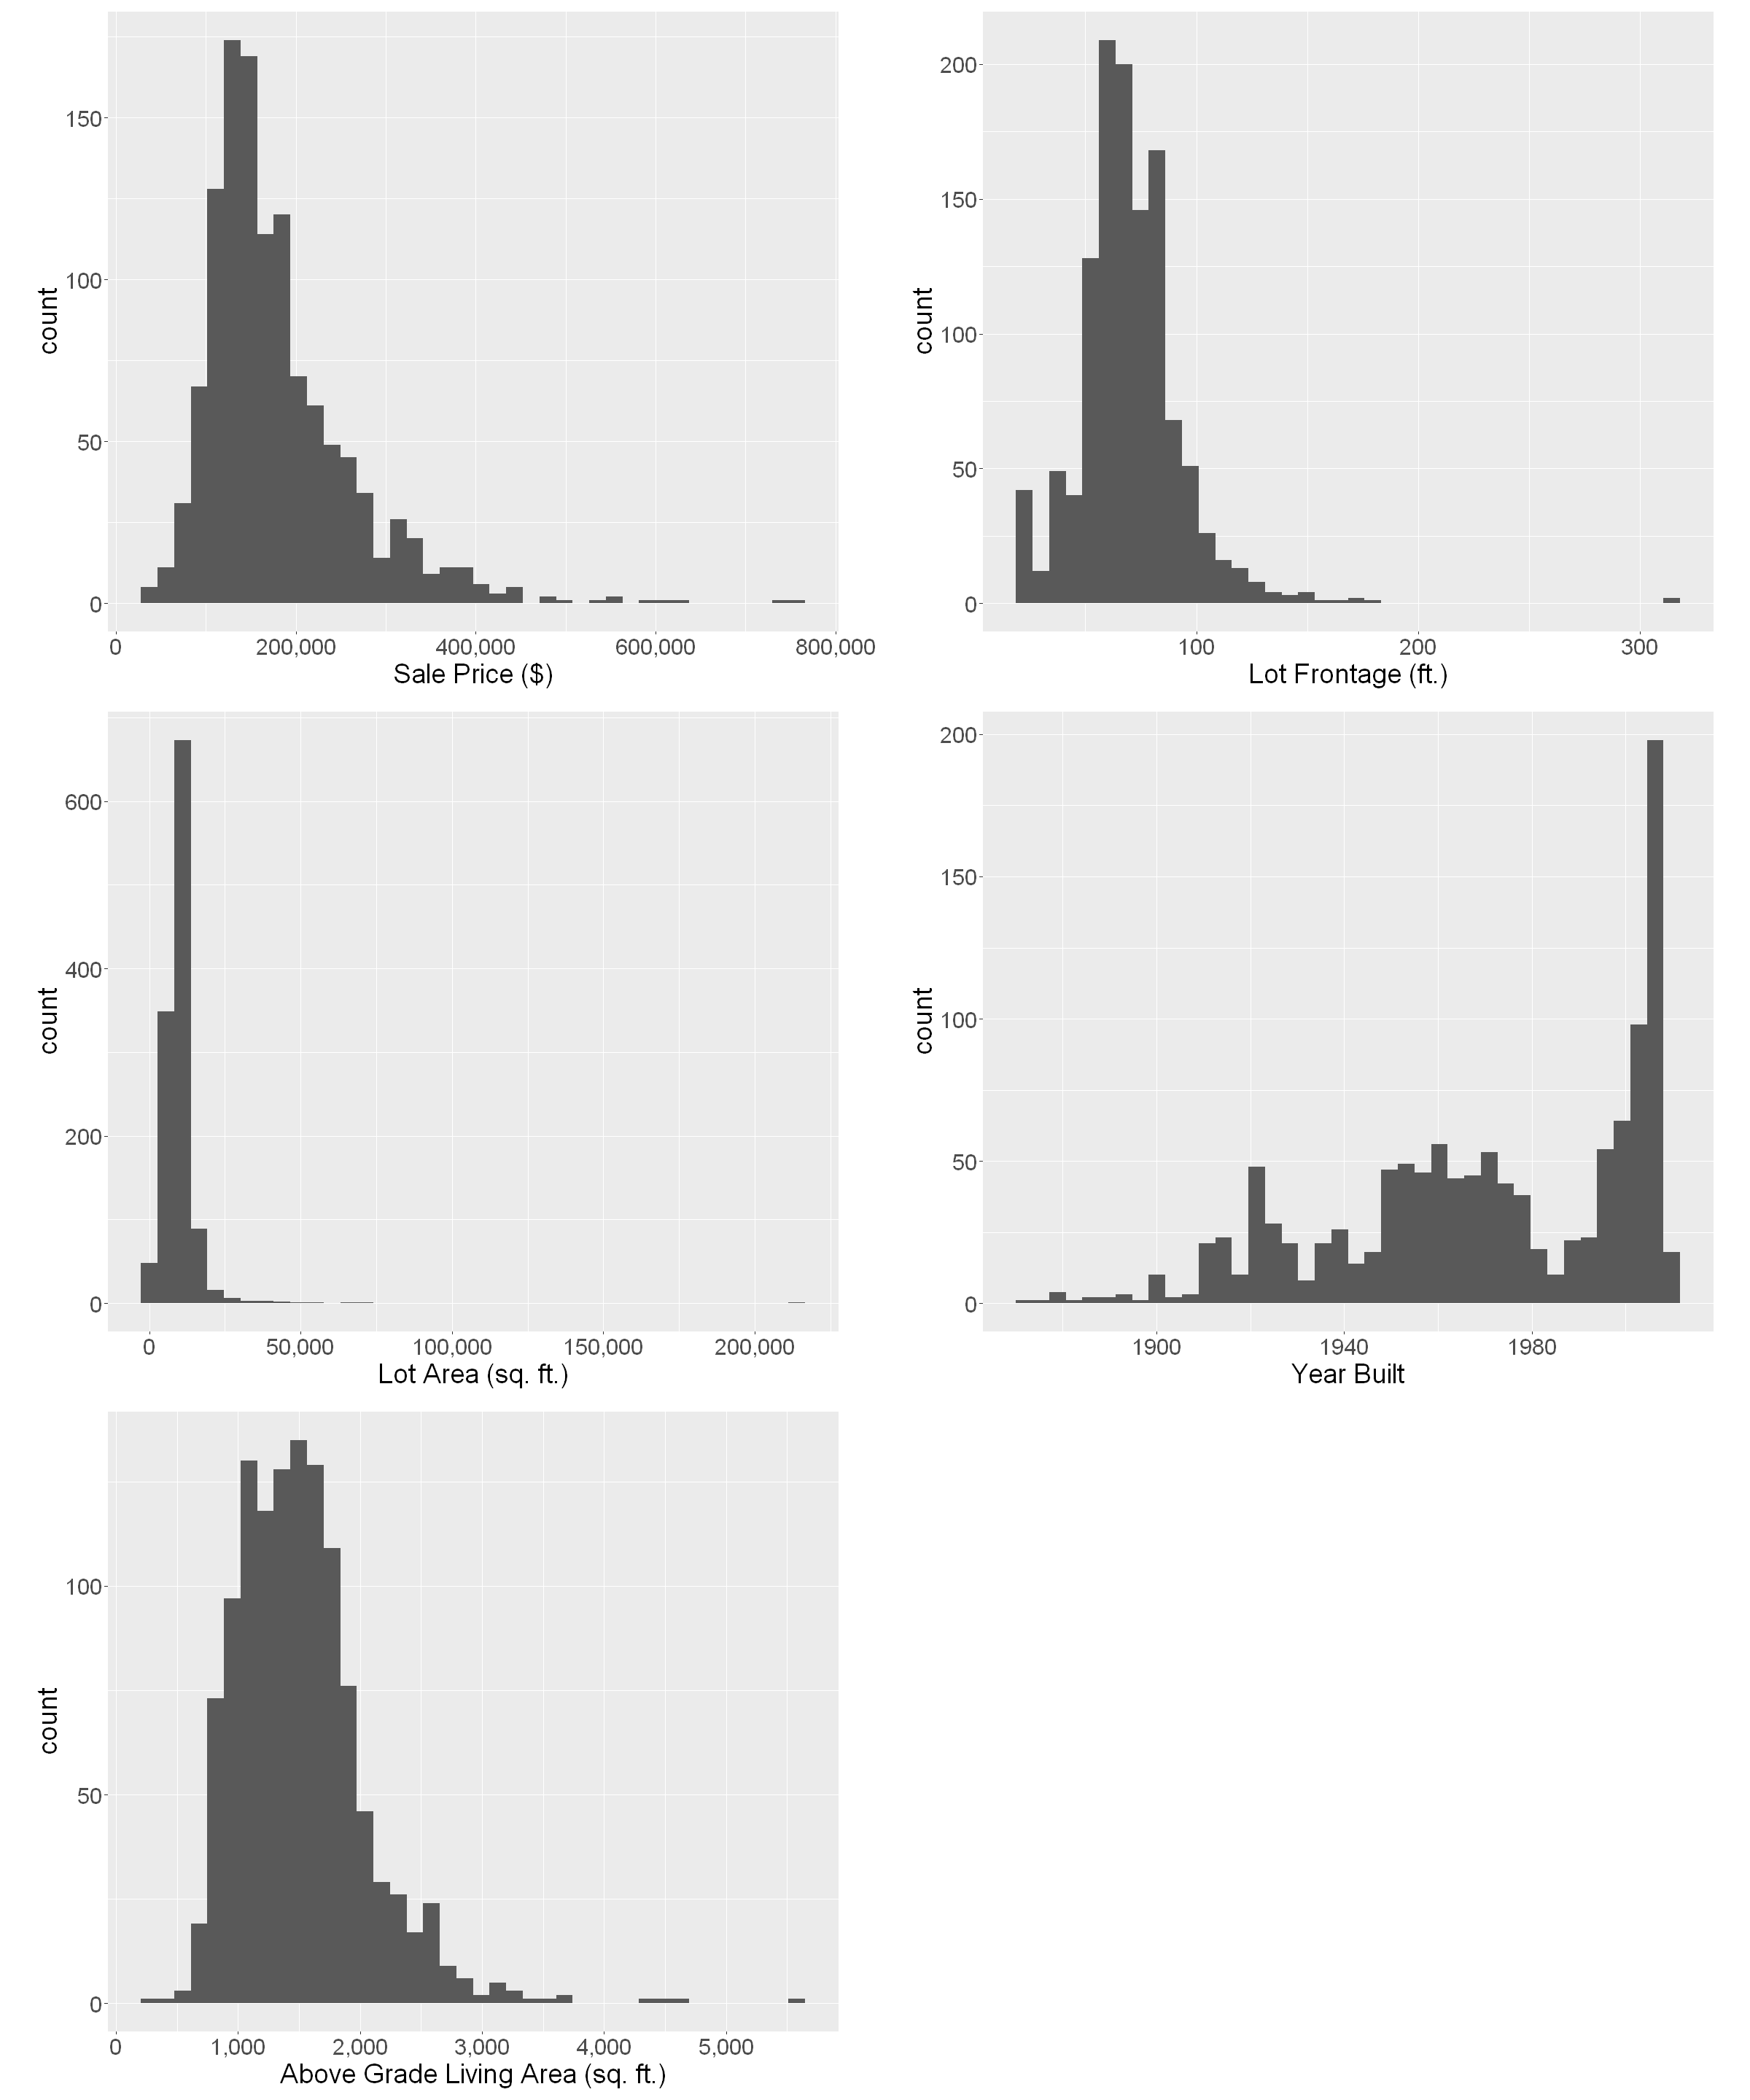

In [6]:
# Set a short list of columns of interest
hist_columns <- c('SalePrice',
                  'LotFrontage',
                  'LotArea',
                  'YearBuilt',
                  'GrLivArea')

histogram_plots(train, hist_columns, 40)

Some observations of the data:

- Sale Price:
    - The home sale price distribution is postively skewed
    - The primary mode is at ~\\$130,000, with a small secondary mode at ~\\$315,000
- Lot Frontage:
    - Lot frontages is also positively skewed. There appear to be a few homes with lot frontages much greater than the rest (>300 ft.).
    - There also appears to be quite a few homes that have very little lot frontage (<50 ft.).
    - The mode is at ~70 ft. frontage.
- Lot Area:
    - While the distribution appears narrow, it is due what appears to be a single home on a lot with an area >200,000 sq. ft. Replotting without this sample may provide more information on the dristribution.
- Year Built:
    - Many homes were build after 1995, but there is also a uneven distribution of older homes. It looks like there was an older home building period between 1950 - 1980 (presumably beginning post-World War II). There a few smaller building periods between 1910 - 1918 (the US entered World War I in 1917), 1922 - 1930 (the Great Depression Started in the US in 1930), and 1936 - 1940 (the New Deal policies started in 1933 and the US entered World War II in the end of 1941).
- Above Grade Living Area:
    - The distribution for home square footage looks quite similar to the distribution for sales price (positively skewed), suggesting house size and sales prices are correlated.

Replot Lot Area without the high value outlier to get a better for for its distribution:

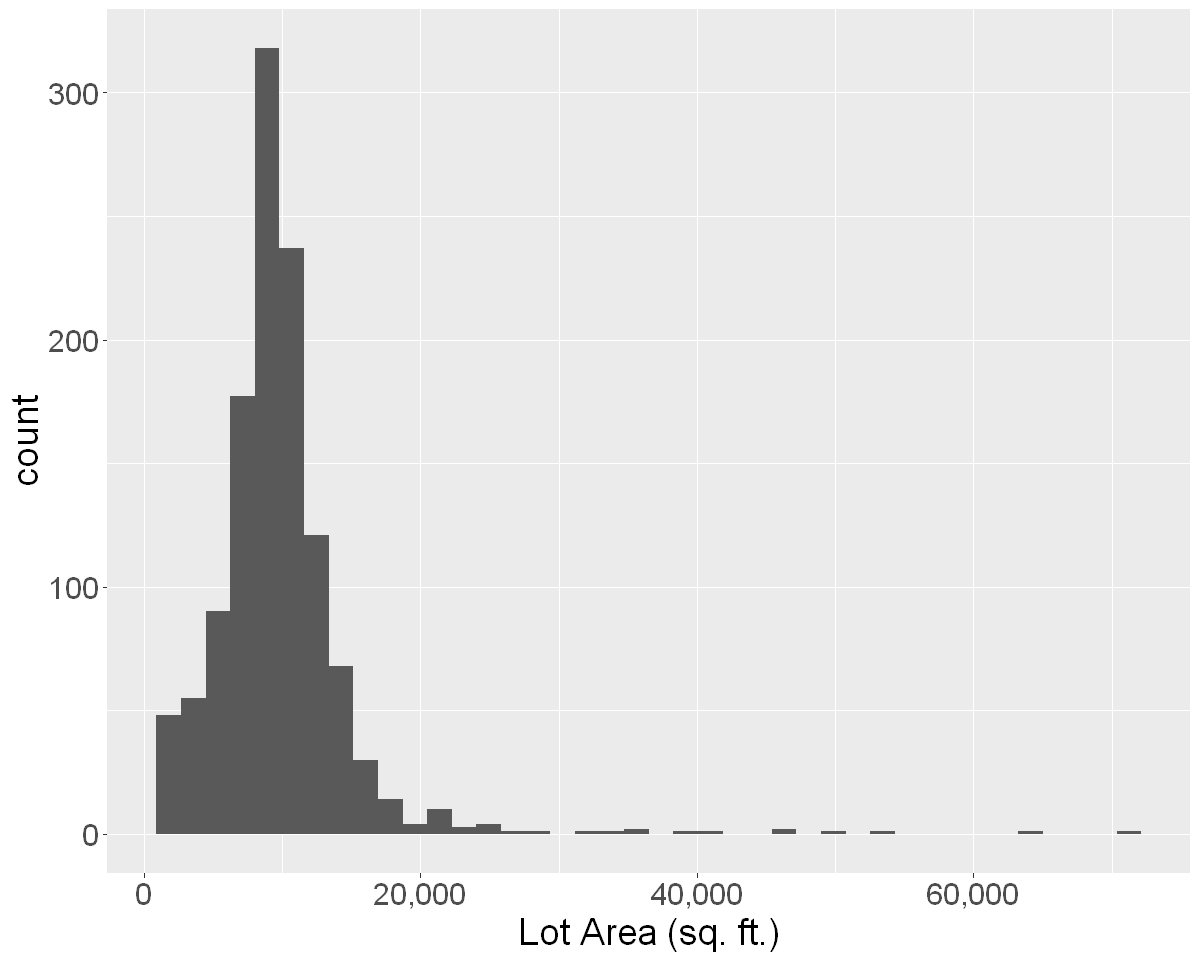

In [7]:
plot_data_column(train %>% filter(LotArea < 200000), 'LotArea', 40, 10, 8)

The distribution for Lot Area now more closely resembles that of Lot Frontage.

Now let's see if these variables impact Sales Price. To do this, first define a set of functions to plot scatter plots to help with visualization:

In [8]:
# Define a function to plot a scatter plot:
plot_scatter <- function(data, x_column, y_column = 'SalePrice', width = 20, height = 18) {
    options(repr.plot.width = width, repr.plot.height = height)
    sctr_plot <- ggplot(data, aes(x = !!sym(x_column), y = !!sym(y_column))) +
      geom_point(size = 3) +
      labs(x = axis_label(x_column), y = axis_label(y_column)) +
      theme(axis.title = element_text(size = 22),
            axis.text = element_text(size = 18))
    lrg_val <- c('SalePrice','LotArea','GrLivArea','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF','GarageArea')
    if (x_column %in% lrg_val) {
        sctr_plot_x <- sctr_plot + scale_x_continuous(label = label_comma())
    } else {
        sctr_plot_x <- sctr_plot
    }
    if (y_column %in% lrg_val) {
        sctr_plot_y <- sctr_plot_x + scale_y_continuous(label = label_comma())
    } else {
        sctr_plot_y <- sctr_plot_x
    }
    return(sctr_plot_y)
}
# Define a function to plot a group of scatter plots and arrange them in two columns
scatter_plots <- function(scatter_data, x_scatter_columns) {
  lapp_columns <- x_scatter_columns
  my_plots <- lapply(lapp_columns, plot_scatter, data = scatter_data)
  grid.arrange(grobs = my_plots, ncol = 2)
}

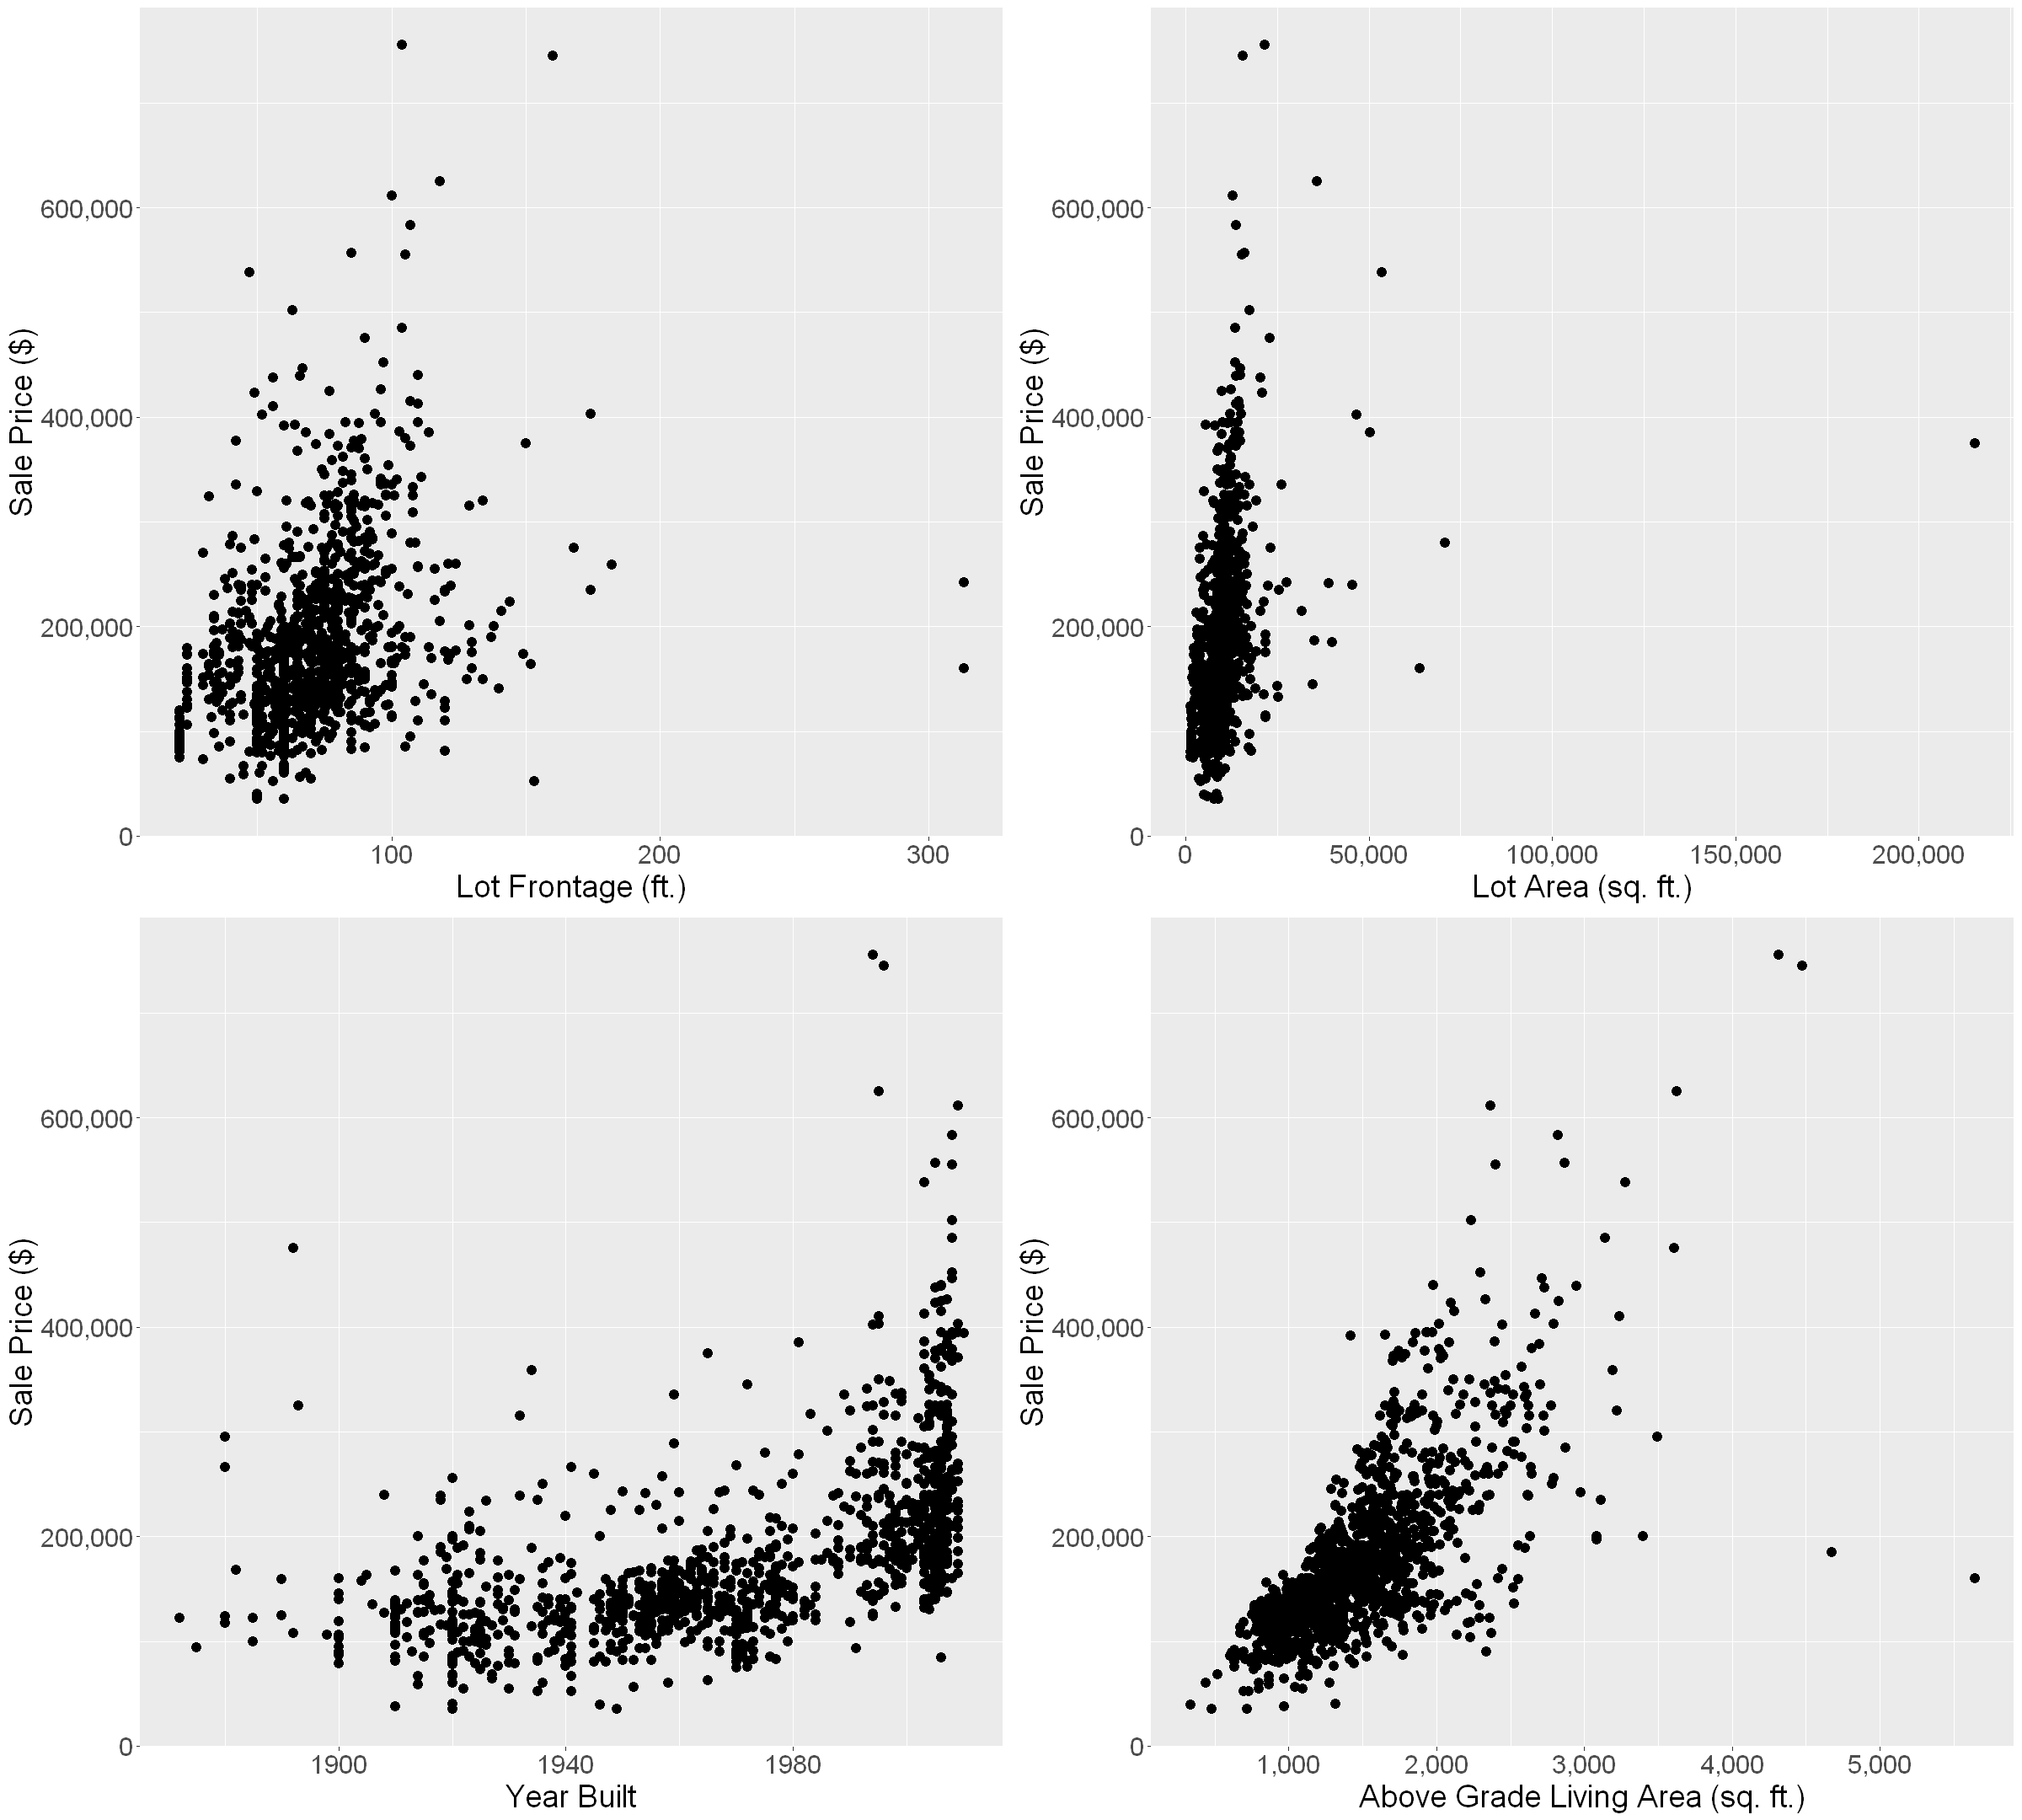

In [9]:
# Define a short list of columns of interest for scatter plots
x_scatter_columns <- c('LotFrontage',
                       'LotArea',
                       'YearBuilt',
                       'GrLivArea')

scatter_plots(train, x_scatter_columns)

Need to remove some outliers and replot:
- Lot frontage > 300 ft.
- Lot area > 200,000 sq. ft.
    - For reference, most house lots in the data set are <75,000 sq. ft., which is ~1.75 acre; 200,000 sq. ft. is >4.5 acre, so this is clearly an outlier that should be removed in the future.
- Above grade living area > 4500 sq. ft.
    - The two homes with living areas this large do not appear to follow the general trend of house price and are probably outliers.

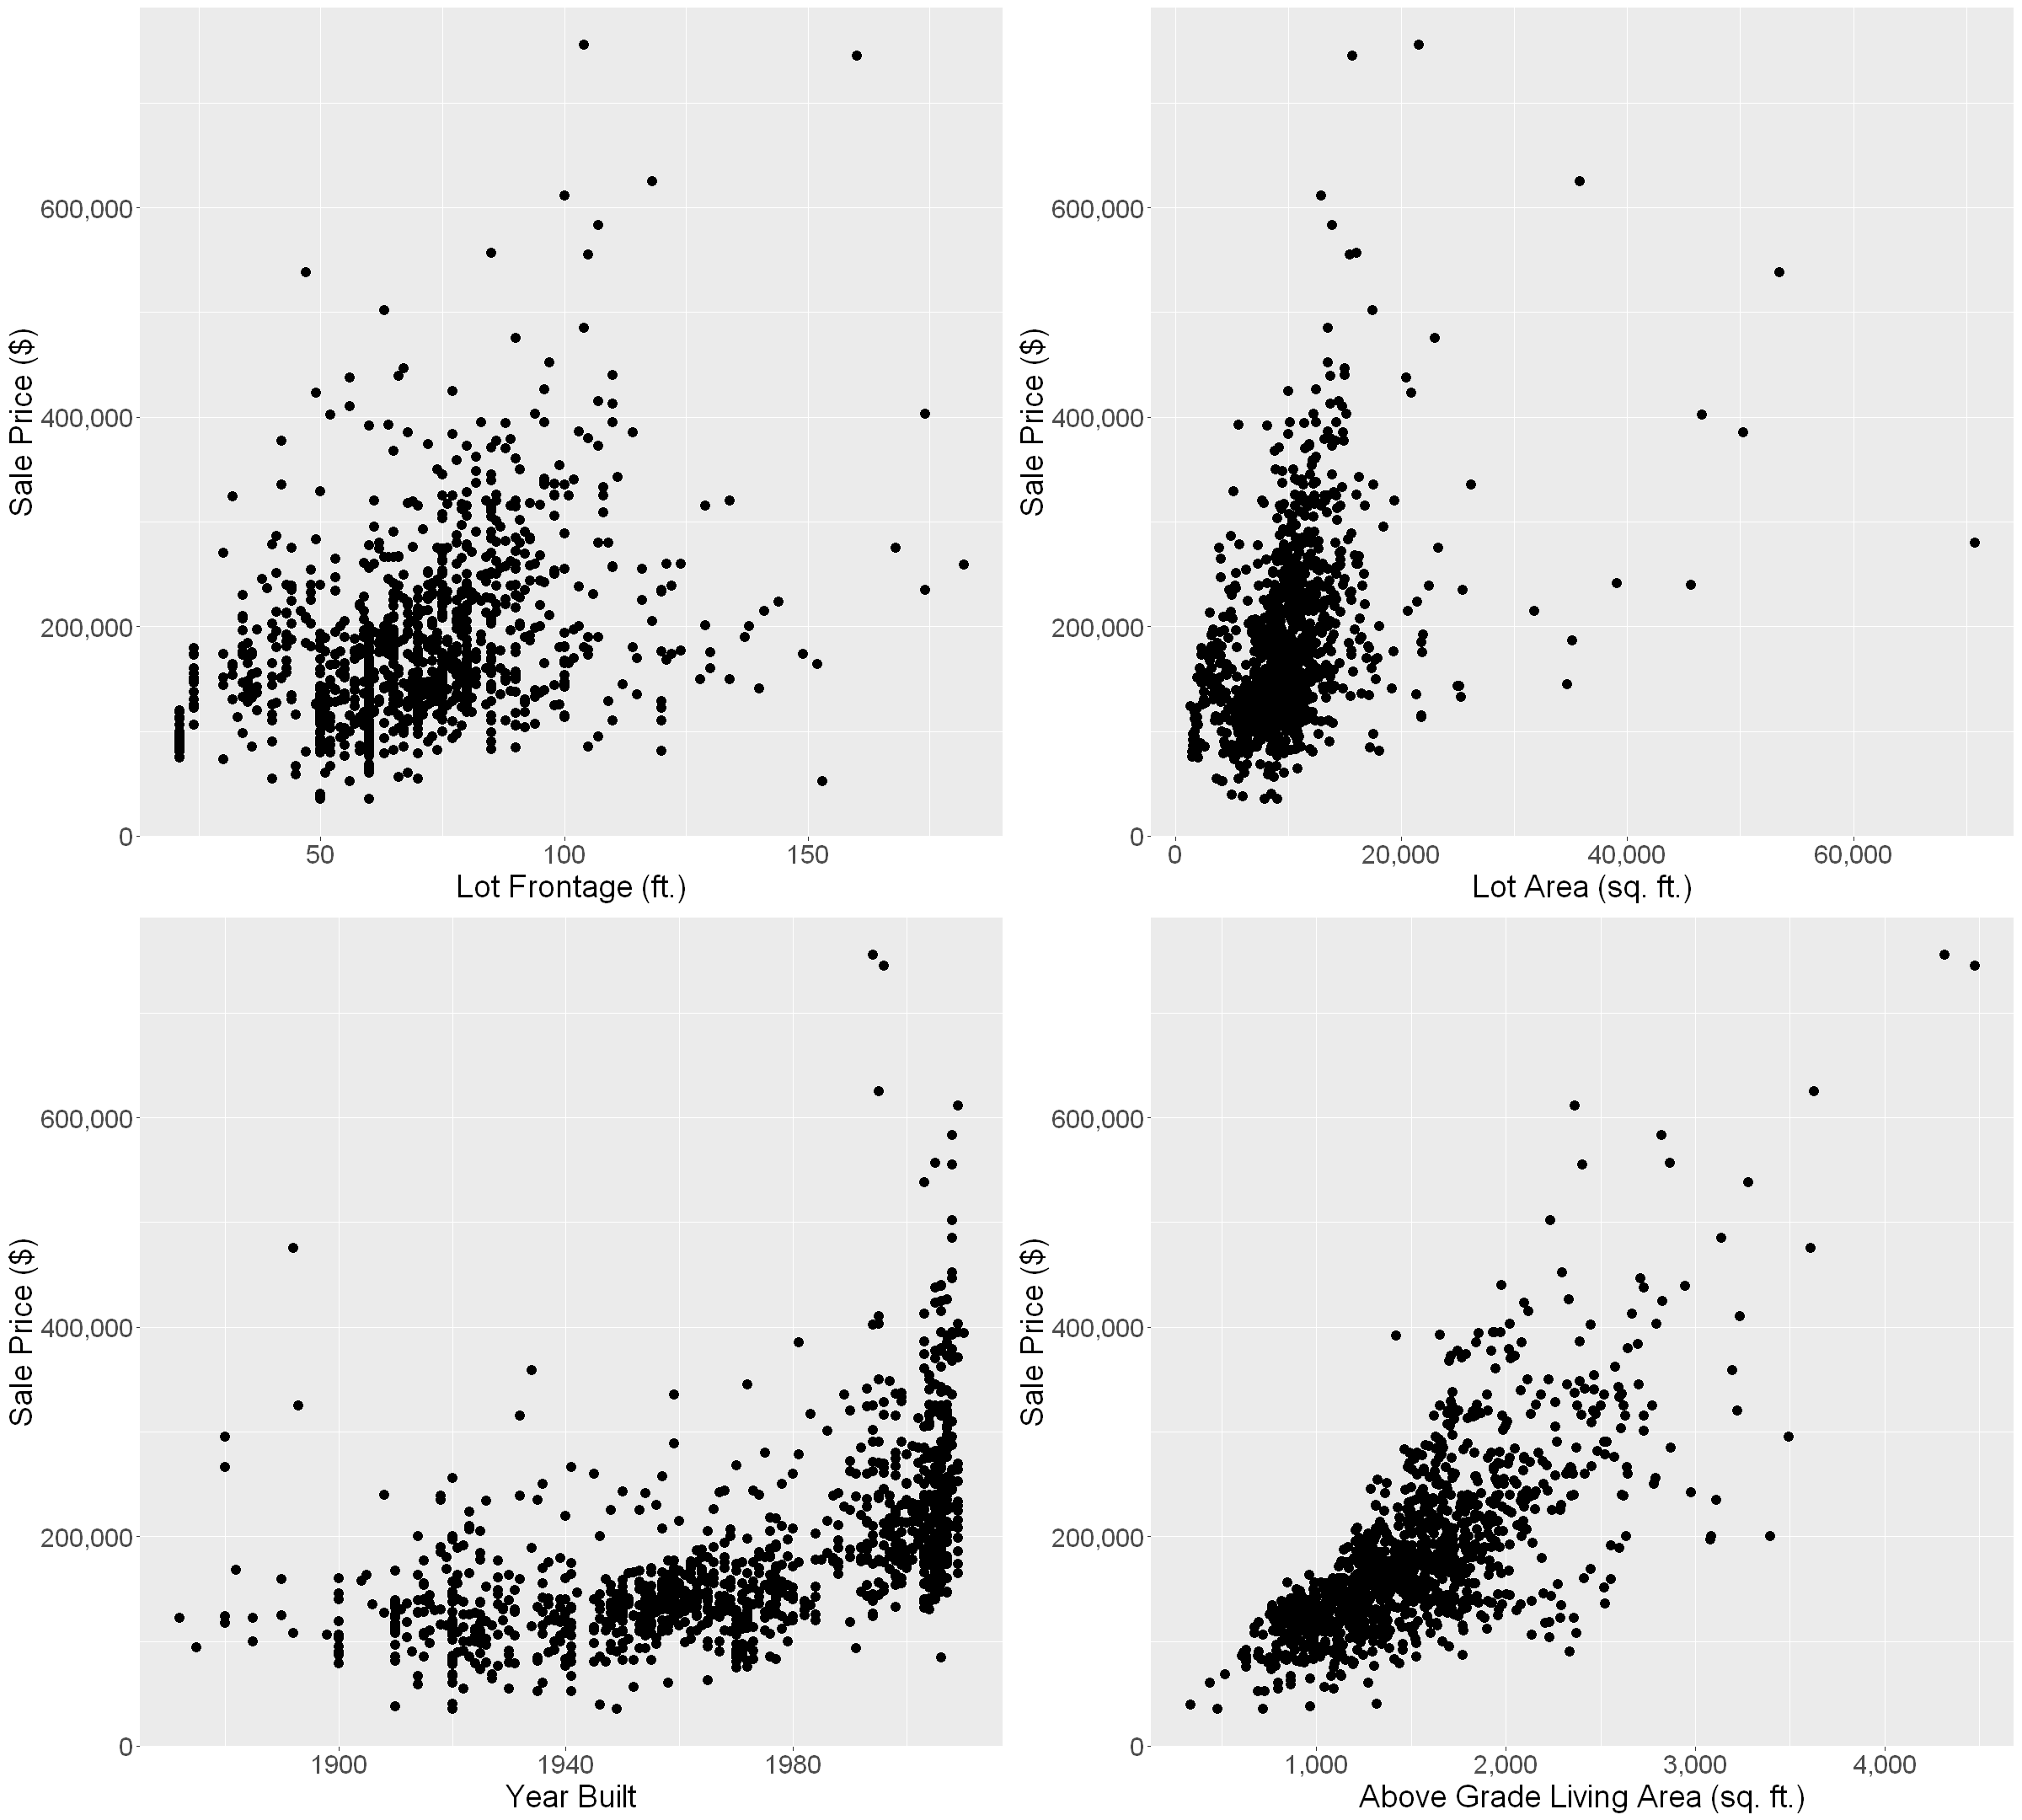

In [10]:
# Use multiple filters via pipes to trim the data of observed outliers
train_sct_trim <- train %>%
    filter(LotFrontage < 300) %>%
    filter(LotArea < 200000) %>%
    filter(GrLivArea < 4500)
scatter_plots(train_sct_trim, x_scatter_columns)

Looks like Sale Price and Living Area may be correlated. Quick calculation of correlation coefficient:

In [11]:
# Define function to evaluate correlation coefficient between SalePrice and other features
scatter_correl <- function(data, columns) {
  for (column in columns) {
    correl <- data %>%
      select(SalePrice, all_of(column)) %>%
      corr()
    cat('The correlation coefficient between Sale Price &', axis_label(column), 'is', round(correl, digits = 3),'\n')
  }
}
scatter_correl(train_sct_trim, x_scatter_columns)

The correlation coefficient between Sale Price & Lot Frontage (ft.) is 0.376 
The correlation coefficient between Sale Price & Lot Area (sq. ft.) is 0.422 
The correlation coefficient between Sale Price & Year Built is 0.542 
The correlation coefficient between Sale Price & Above Grade Living Area (sq. ft.) is 0.736 


Observations:
- Sale Price has a weak positive correlation with Lot Frontage & Lot Area
- Sale Price also has a weak positive correlation with the year the house was built in, but the relationship looks like it may be non-linear, so this number should not be taken at face value.
- Sale Price is positively correlated with house living area.

Let check to see if the slight uptick in Sale Price with newer homes is due to newer homes being larger than older homes:

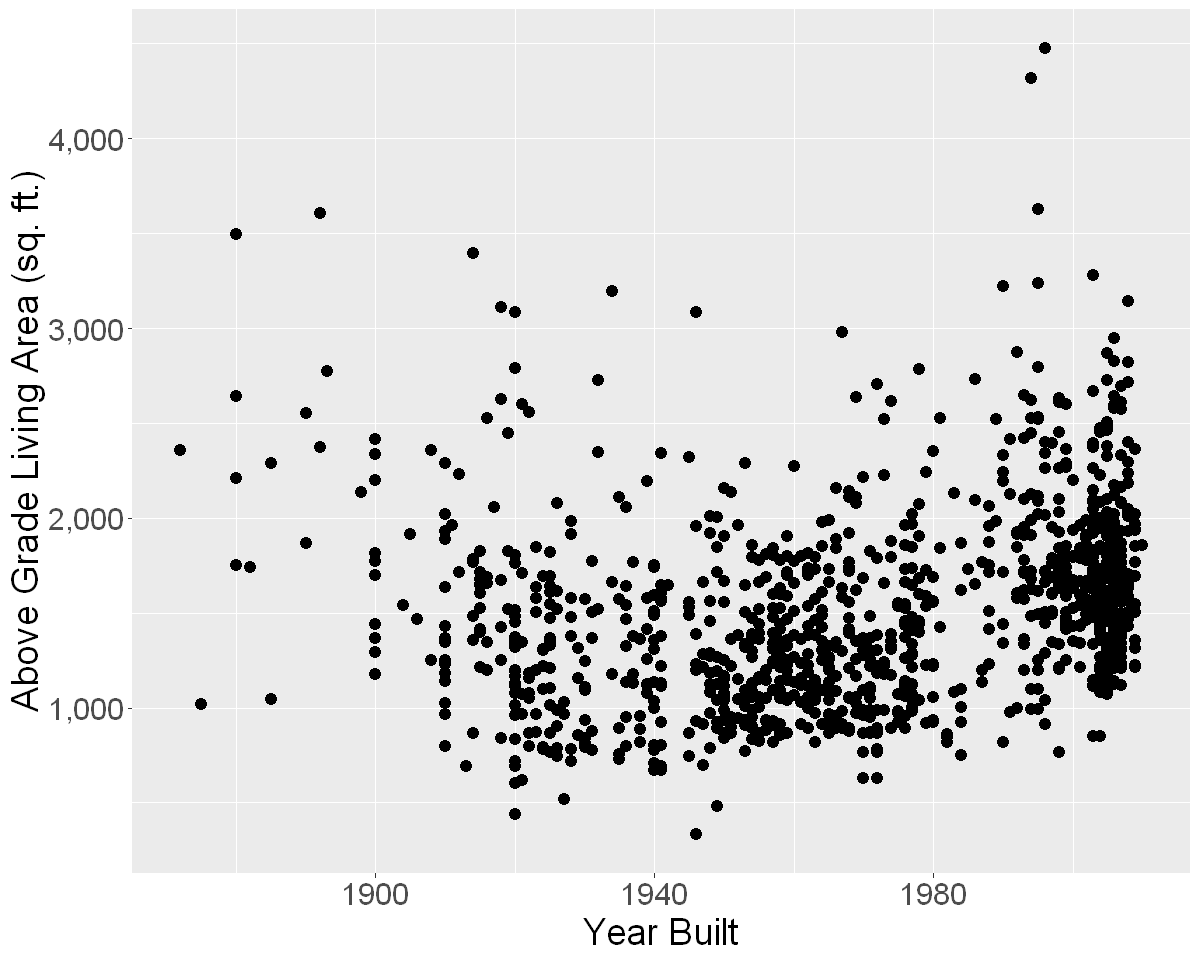

In [12]:
plot_scatter(train_sct_trim, 'YearBuilt', 'GrLivArea', 10, 8)

That does not appear correlated at all, so the impact of house age on sale price appears independent of its size.


Some of the other 'continuous' variables that may be worth examing include:

- YearRemodAdd: year remodeled, but contains the original house construction year if there was no remodel. This may have an impact on sale price.
- MasVnrArea: only relevant if the house contains a masonry vaneer; will need to examine the categorical variable for masonry type (MasVnrType) first (in Part 3 of the Exploratory Data Analysis).
- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF: Various measurements of finished / unfinished / total basement area. Examine if total basement area appears relavent first before looking at subdivisions.
- 1stFlrSF, 2ndFlrSF, LowQualFinSF: subdivisions of above grade living area. Worth looking at since there does appear to be a correlation between total above grade area and sale price.
- BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Bedroom, Kitchen, Fireplaces: these might technically be continuous variables, but the values area all quite low since they are counts of bathrooms, bedrooms, kitchens, etc. These features are probably more similar to the categorical variables.
- TotRmsAbvGrd: total rooms above grade; probably confounded with total above grade area.
- GarageYrBlt, GarageCars, GarageArea: garage age and area may impact sales price.
- WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea: deck, porch & pool may also impact sales price.
- MiscVal: micellaneous feature value; from the description this value sounds semi-arbitrary
- MoSold, YrSold: The month and year of the sale can be treated as categorical values (the latter because range is only 2006 - 2010).

Let's start with remodel year. For visualization purposes, it is worth removing homes that were not remodeled, which is indicated in the data by home remodel year being the same as the home construction year.

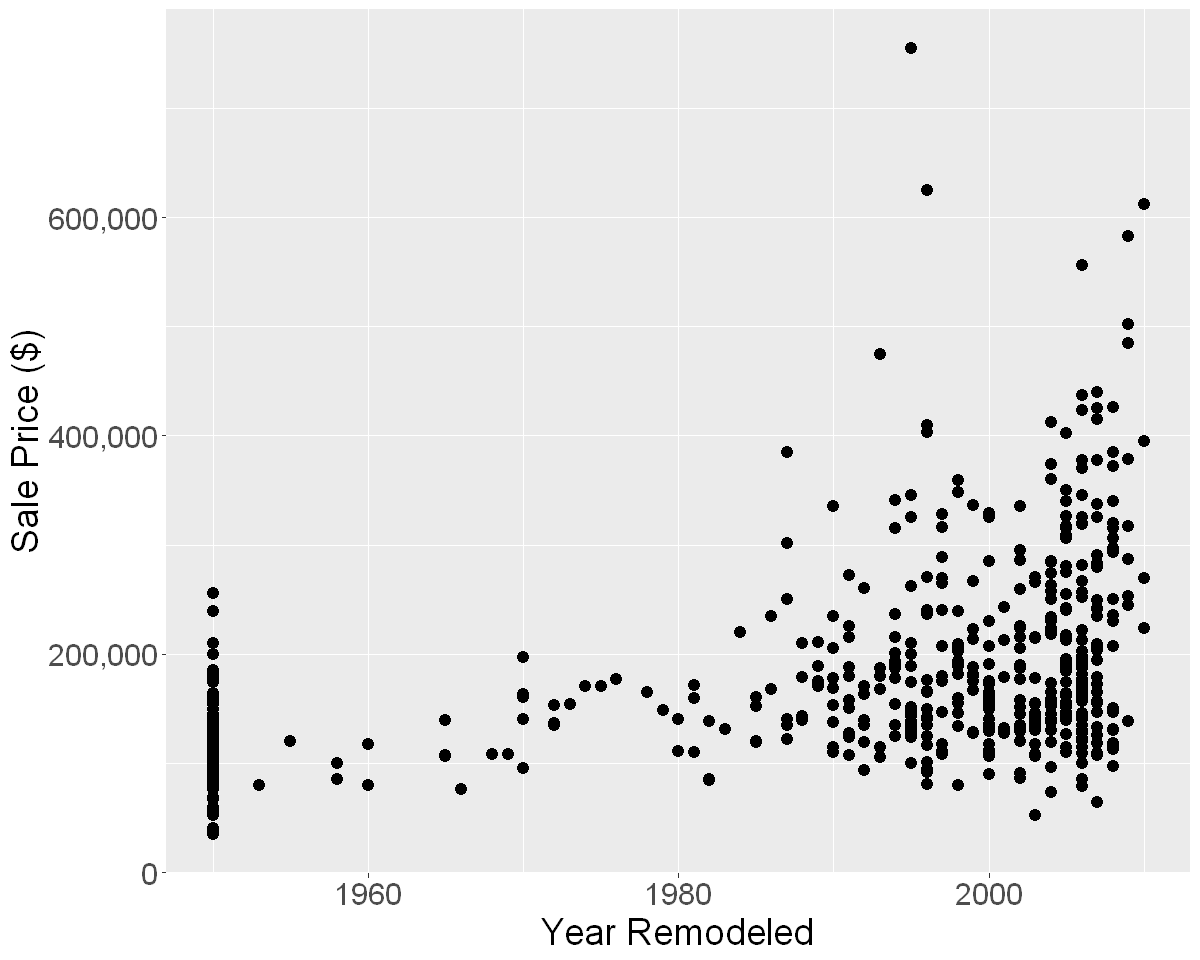

In [13]:
plot_scatter(train_sct_trim %>% filter(YearBuilt != YearRemodAdd), 'YearRemodAdd', 'SalePrice', 10, 8)

Doesn't look like much correlation between sale price and remodel year. However there is something strange with this data. The oldest house in the data set was built in 1872, the oldest remodel was done in 1950. This suggests that the remodel year (where appropriate) for homes built before 1950 is not accurate, and that '1950' is being used as a placeholder.

Now to see if total basement area is relevant:

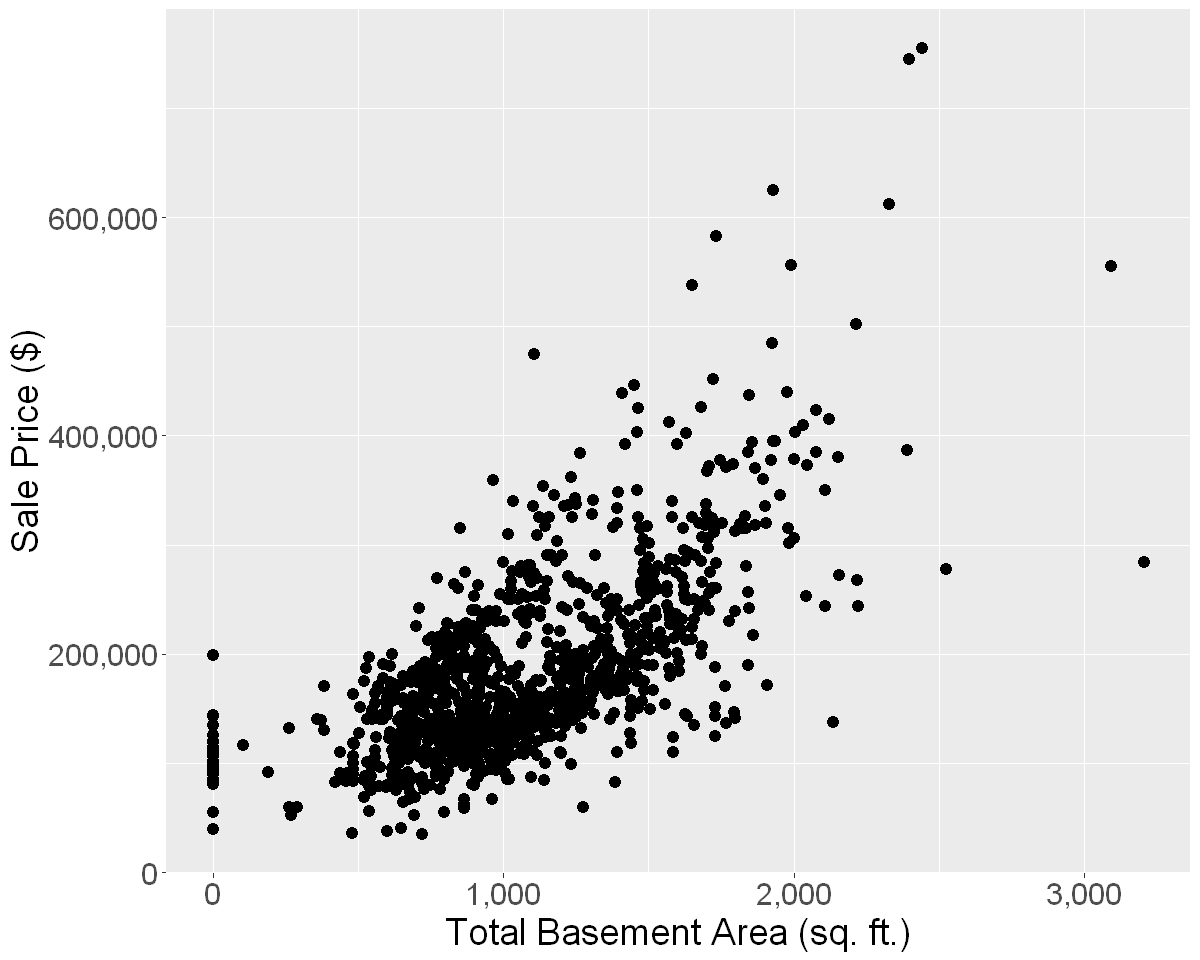

In [14]:
plot_scatter(train_sct_trim, 'TotalBsmtSF', 'SalePrice', 10, 8)

Looks correlated. Quantifying:

In [15]:
scatter_correl(train_sct_trim, 'TotalBsmtSF')

The correlation coefficient between Sale Price & Total Basement Area (sq. ft.) is 0.671 


Not as strongly correlated as the above grade area with sale price, but it's enough that it should be considered. Let's see if any of the subdivisions have more or less of an impact.

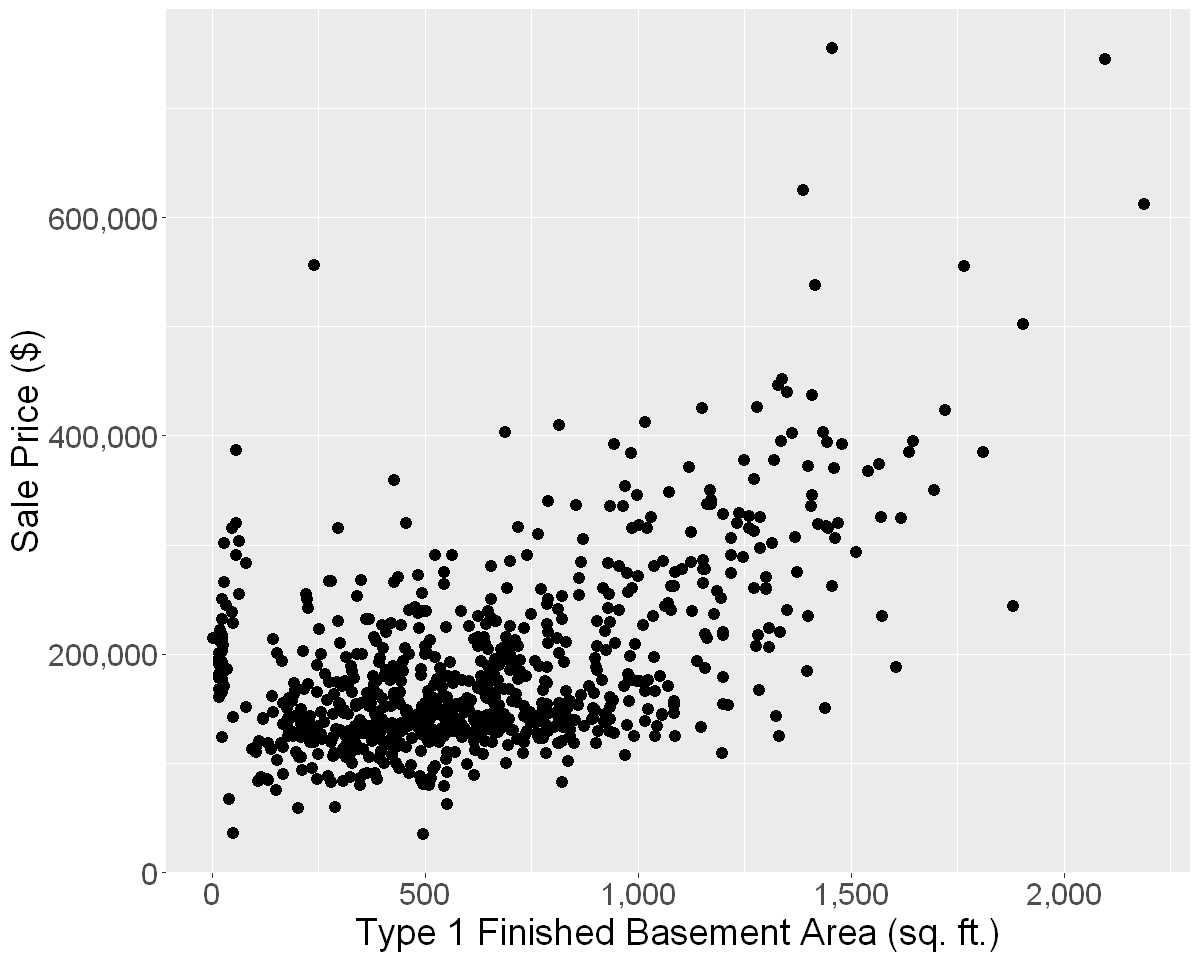

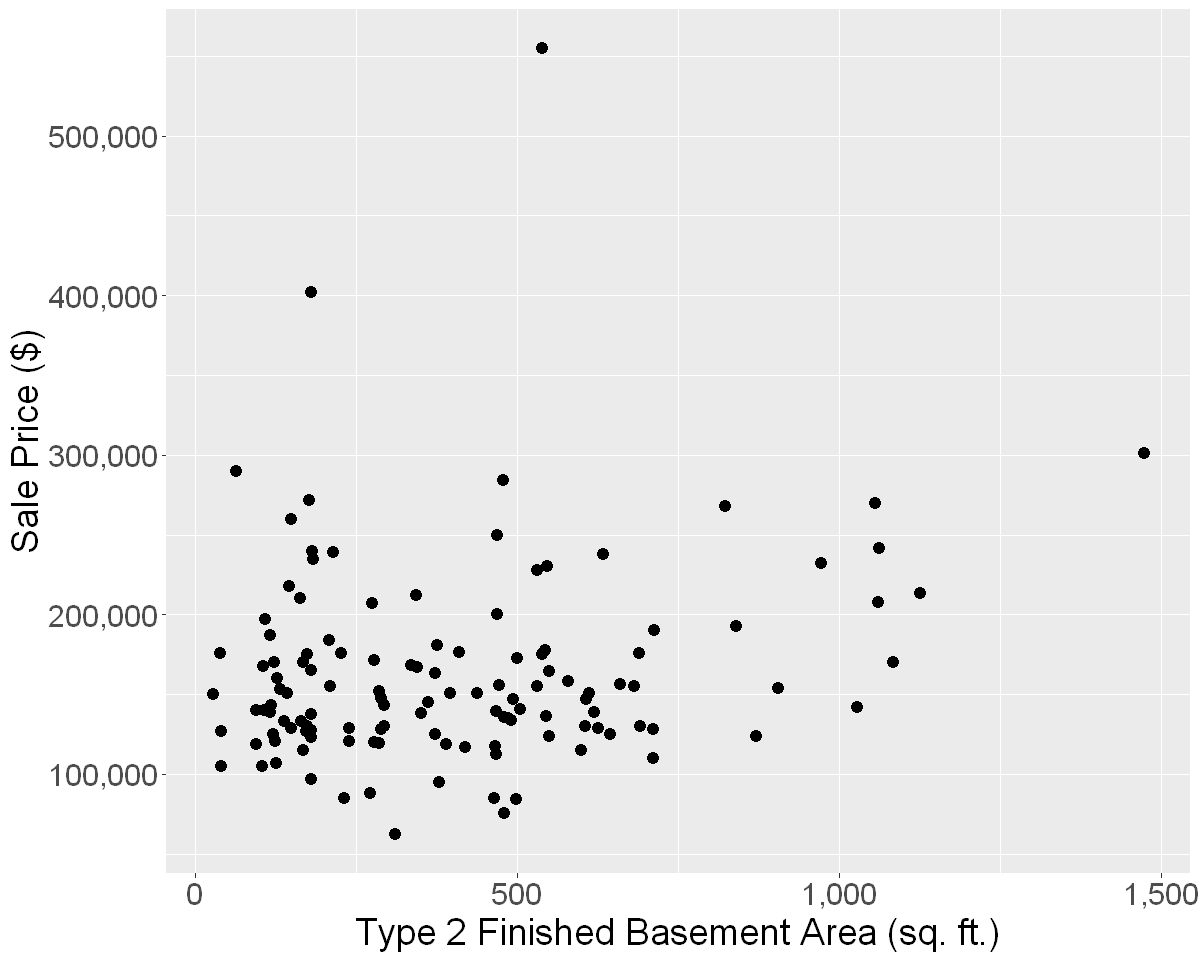

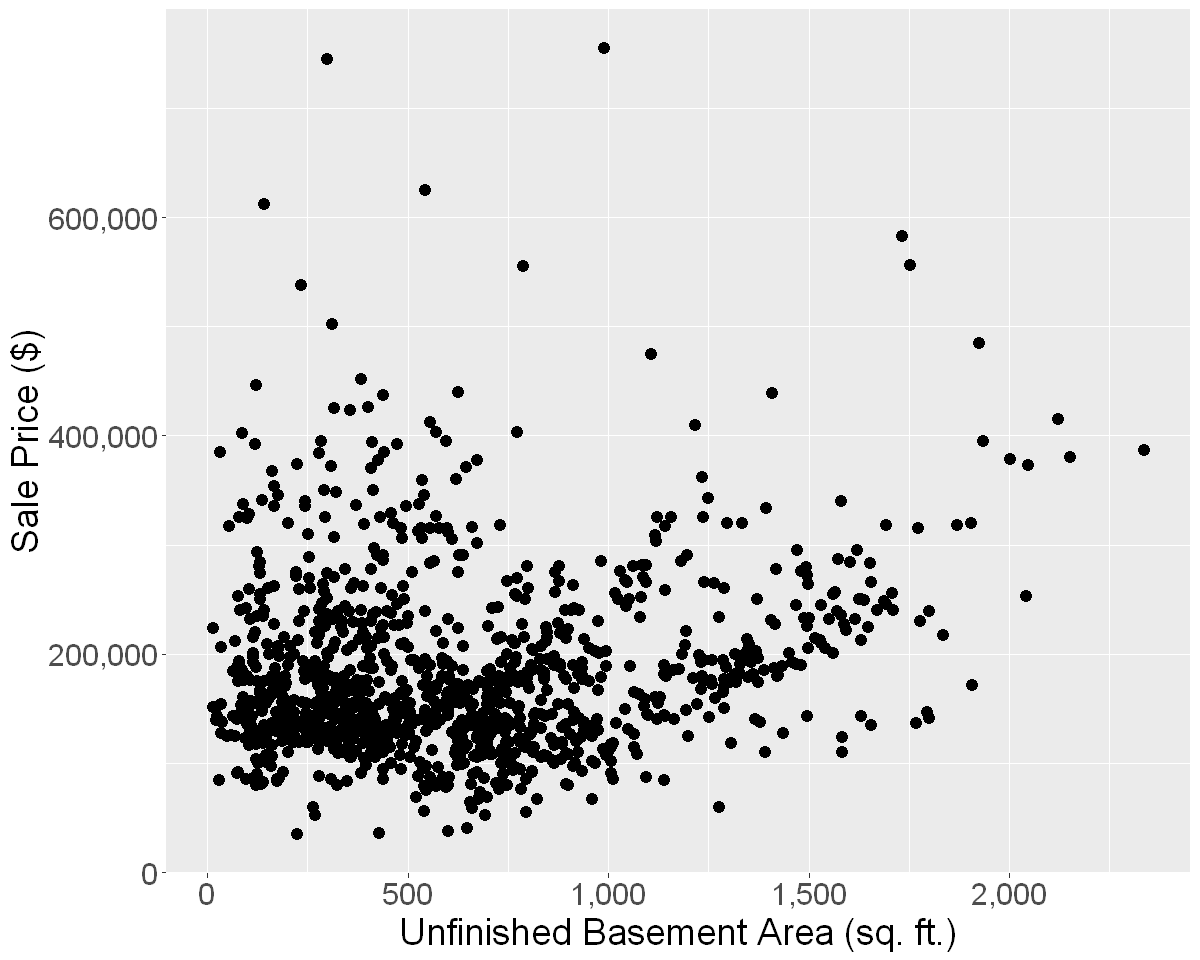

In [16]:
# Only plot houses with that have non-zero area in each category of basements, to avoid a large number of points at 0 sq. ft.
# Do this by filtering out values where area is zero sq. ft. in these columns.
plot_scatter(train_sct_trim %>% filter(BsmtFinSF1 != 0), 'BsmtFinSF1', 'SalePrice', 10, 8)
plot_scatter(train_sct_trim %>% filter(BsmtFinSF2 != 0), 'BsmtFinSF2', 'SalePrice', 10, 8) # only non-zero if there is a second type of finishing used in the basement
plot_scatter(train_sct_trim %>% filter(BsmtUnfSF != 0), 'BsmtUnfSF', 'SalePrice', 10, 8)

In [17]:
# Check correlation coefficients for the three basement subdivisions
scatter_correl(train_sct_trim %>% filter(BsmtFinSF1 != 0) %>% filter(BsmtFinSF2 != 0) %>% filter(BsmtUnfSF != 0),
               c('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'))

The correlation coefficient between Sale Price & Type 1 Finished Basement Area (sq. ft.) is 0.524 
The correlation coefficient between Sale Price & Type 2 Finished Basement Area (sq. ft.) is 0.184 
The correlation coefficient between Sale Price & Unfinished Basement Area (sq. ft.) is 0.356 


Both visually and quantitatively, the total basement area appears to be the most correlated with sale price. For feature selection for an eventual model, it may be better to use this feature, rather than subdividing and using finished / unfinished area as features.

Now let's look at above grade living area subdivisions to see if any of these have and outsized influence over the others on sale price.

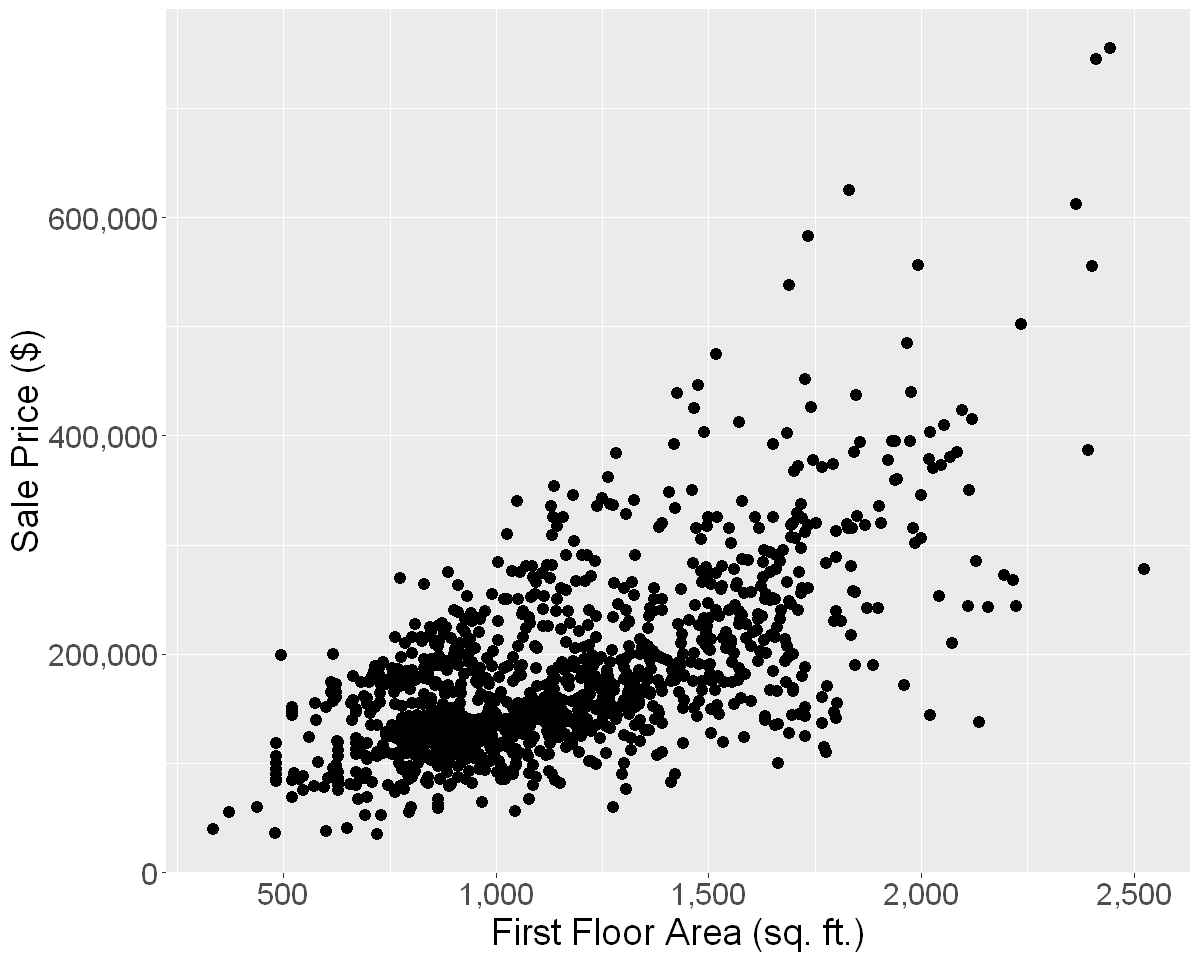

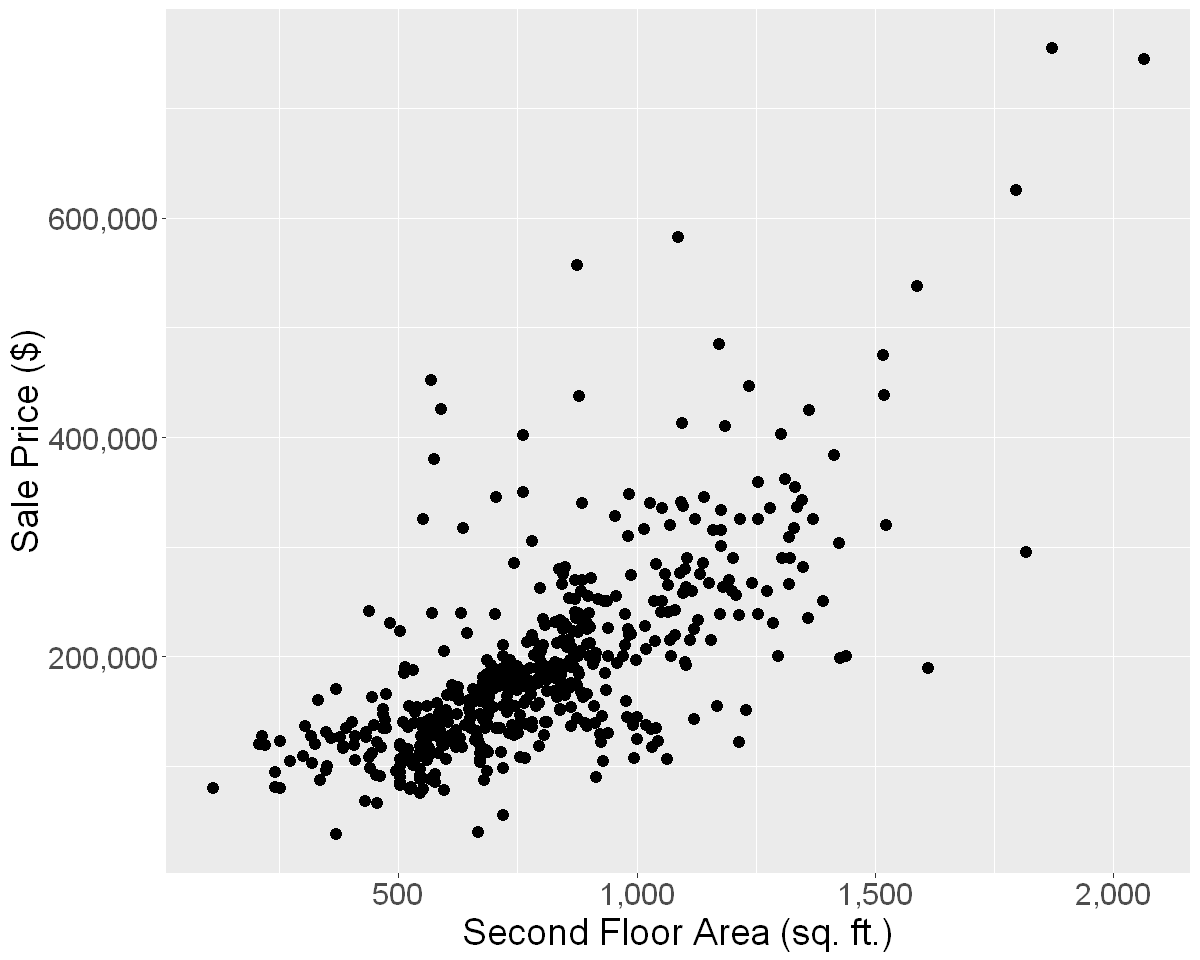

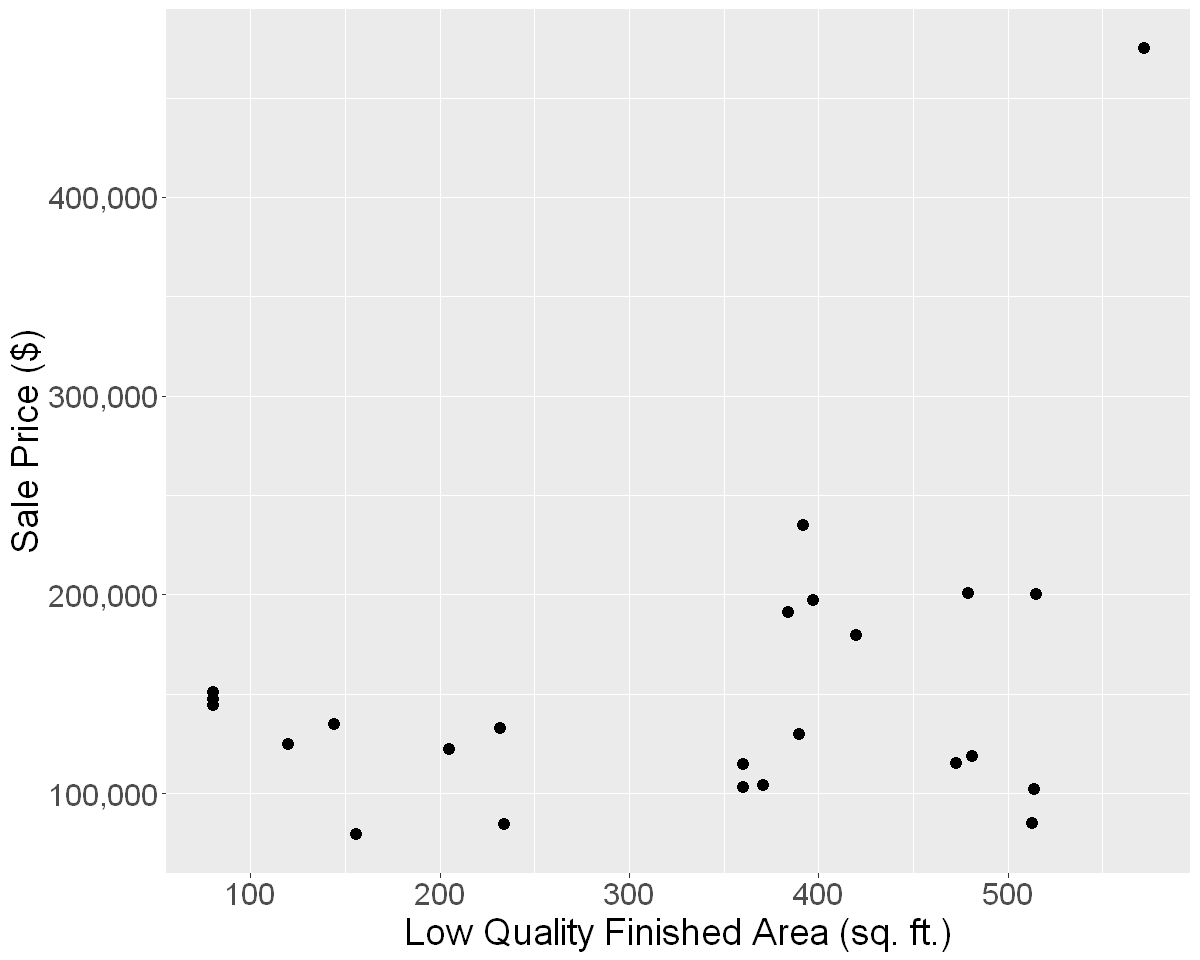

In [18]:
# As with basement area, let's remove instances where the 2nd floor doesn't exist or there is no low quality finished area (both theoretically when 0 sq. ft.)
plot_scatter(train_sct_trim, '1stFlrSF', 'SalePrice', 10, 8)
plot_scatter(train_sct_trim %>% filter(`2ndFlrSF` != 0), '2ndFlrSF', 'SalePrice', 10, 8)
plot_scatter(train_sct_trim %>% filter(LowQualFinSF != 0), 'LowQualFinSF', 'SalePrice', 10, 8)

In [19]:
# Check correlation coefficients for three above grade living area subdivisions
scatter_correl(train_sct_trim, '1stFlrSF')
scatter_correl(train_sct_trim %>% filter(`2ndFlrSF` != 0), '2ndFlrSF')
scatter_correl(train_sct_trim %>% filter(LowQualFinSF != 0), 'LowQualFinSF')

The correlation coefficient between Sale Price & First Floor Area (sq. ft.) is 0.65 
The correlation coefficient between Sale Price & Second Floor Area (sq. ft.) is 0.696 
The correlation coefficient between Sale Price & Low Quality Finished Area (sq. ft.) is 0.361 


Moderate positive correlation between sale price and the 1st & 2nd floor areas, but no correlation between low quality finished area. This is not surprising based on intuition, as 'low quality' square footage seems unlikely to (positively) impact sale price. This suggests a couple options for feature selection:
- Use First Floor Area and Second Floor Area as separate features in the model
- Combine the area contributions from both the first and second floor into the model

Moving on, let's check if total rooms above grade appears confounded with total area above grade.

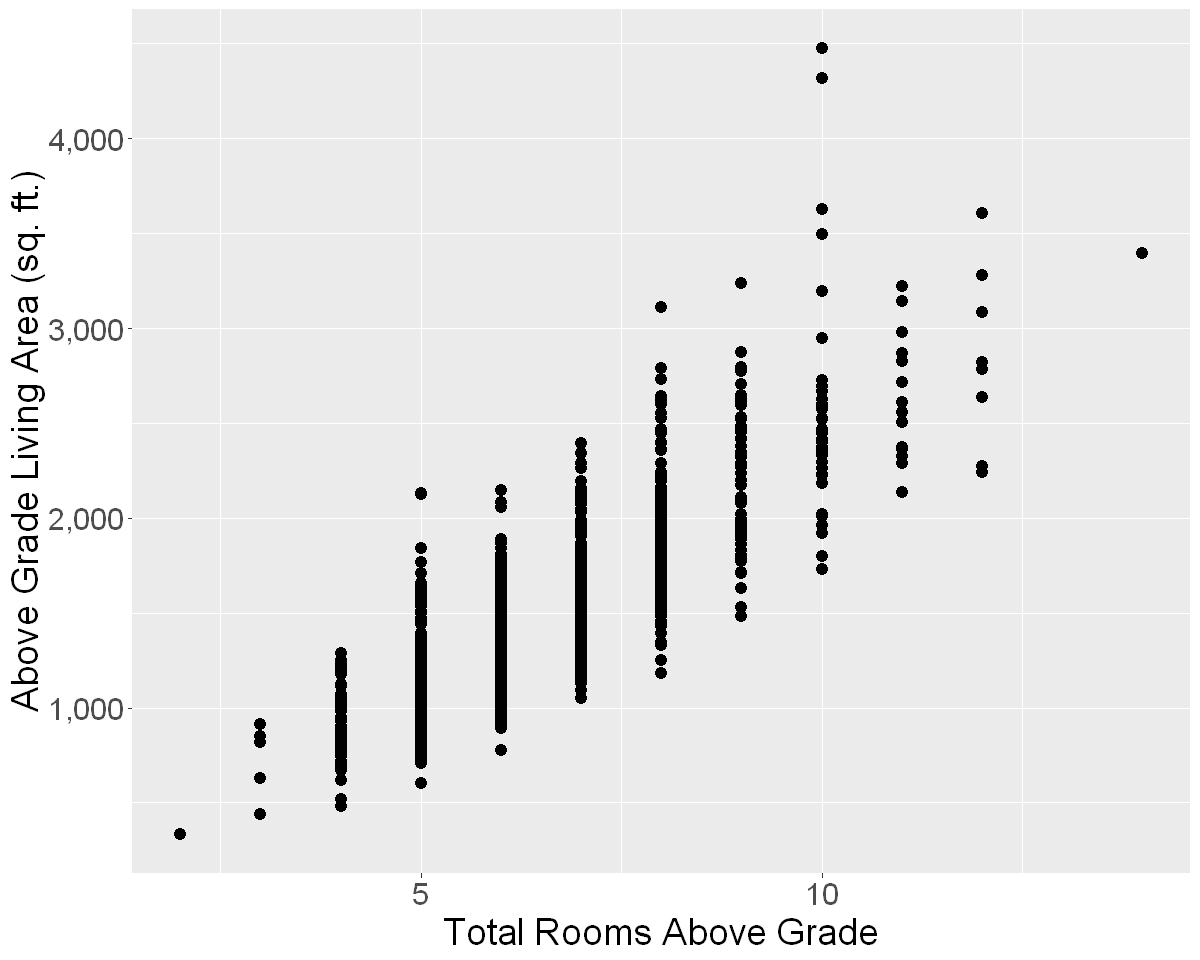

In [20]:
plot_scatter(train_sct_trim, 'TotRmsAbvGrd', 'GrLivArea', 10, 8)

Looks like only one of these features will be needed.

The garage probably has some impact on the sale price. Let's look at age and size:

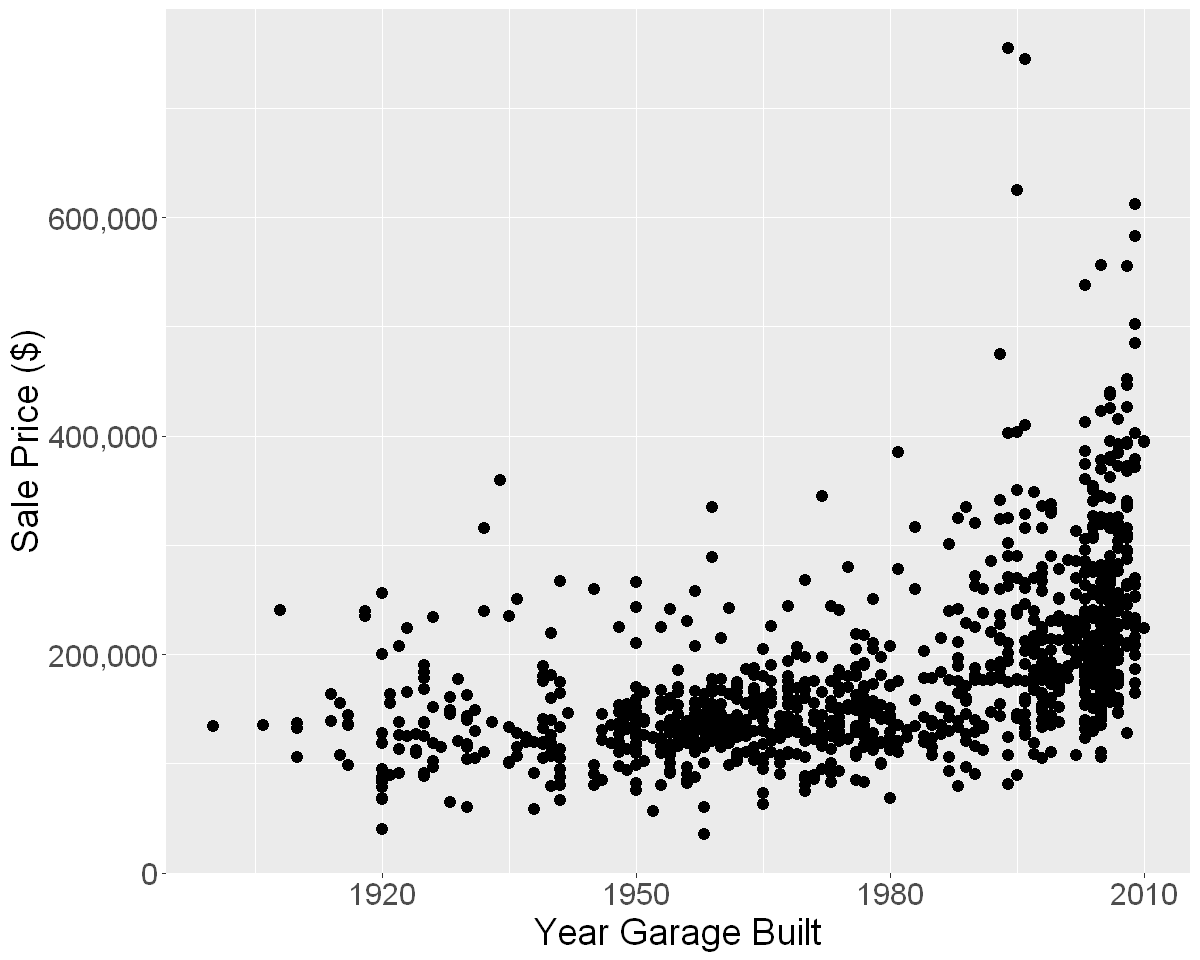

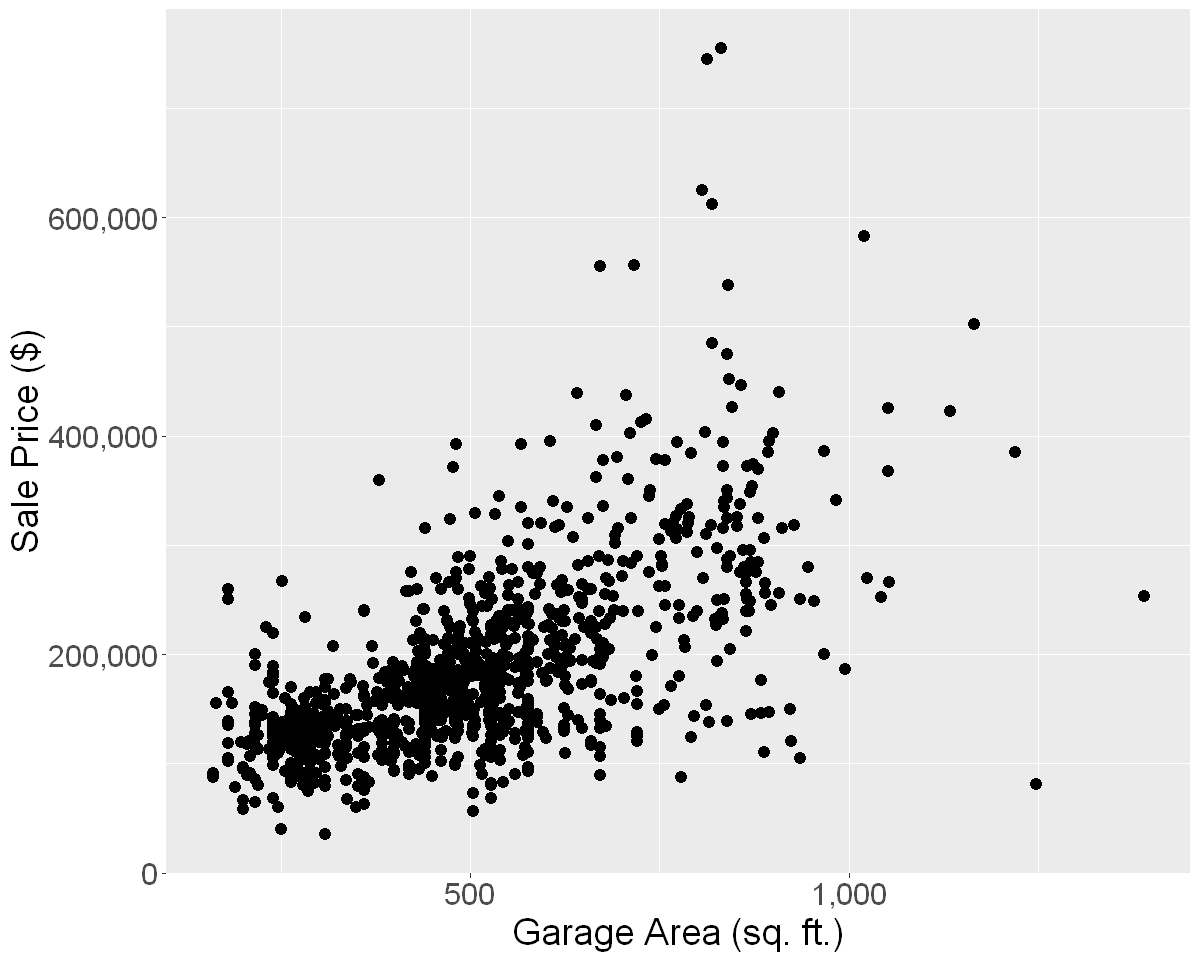

In [21]:
# Remove homes that don't have a garage before plotting
plot_scatter(train_sct_trim %>% drop_na('GarageYrBlt'), 'GarageYrBlt', 'SalePrice', 10, 8)
plot_scatter(train_sct_trim %>% drop_na('GarageYrBlt'), 'GarageArea', 'SalePrice', 10, 8)

Looks like there is a weak correlation between sale price and garage size.

The increasing trend in sale price with the year of garage construction is probably similar to the same trend observed with sale price and year of house construction. Let's see when these garages were build relative to their homes:

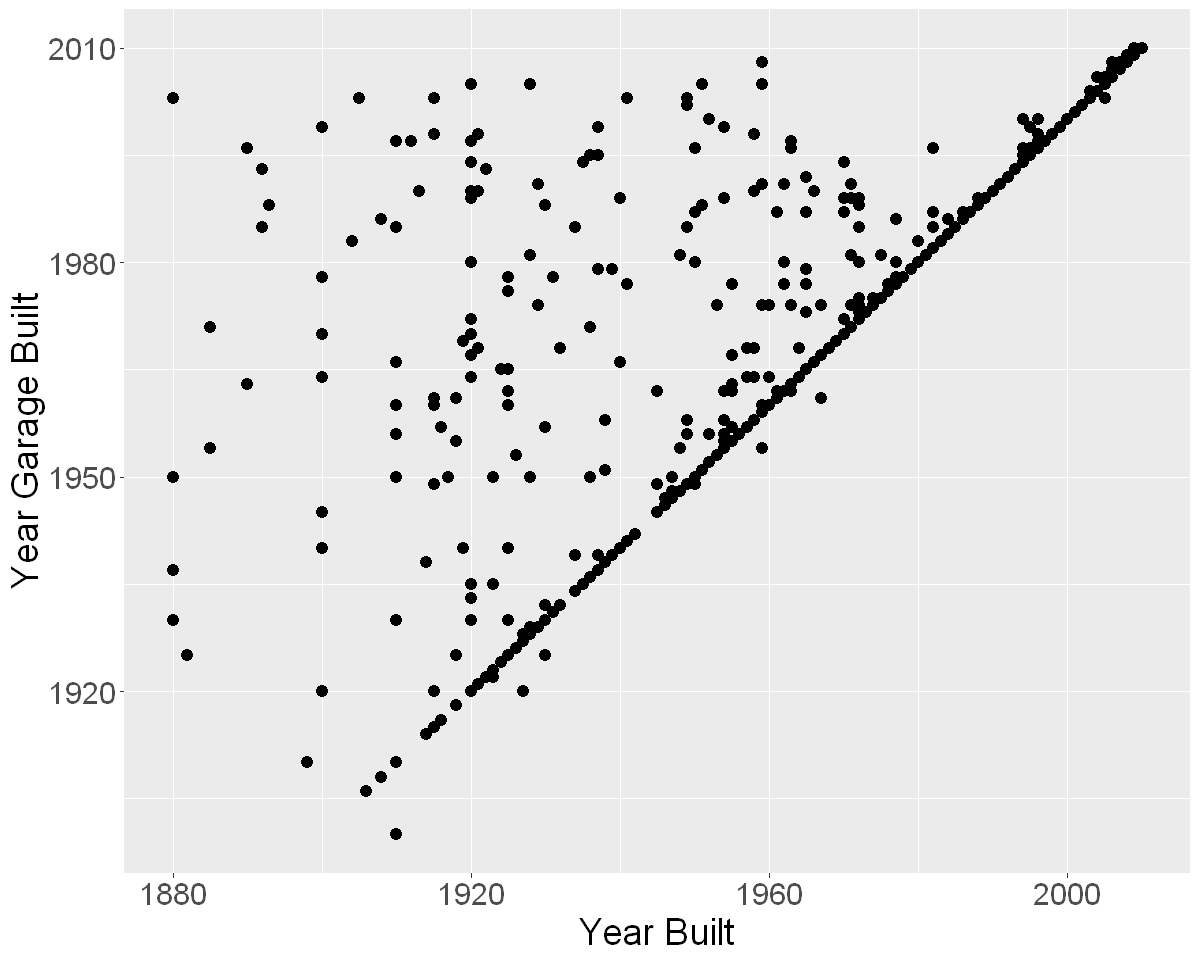

In [22]:
plot_scatter(train_sct_trim %>% drop_na('GarageYrBlt'), 'YearBuilt', 'GarageYrBlt', 10 , 8)

A significant fraction appear to have built at the same time as the home. Something to check here would be to see if a garage built after the house can increase the potential sale price.

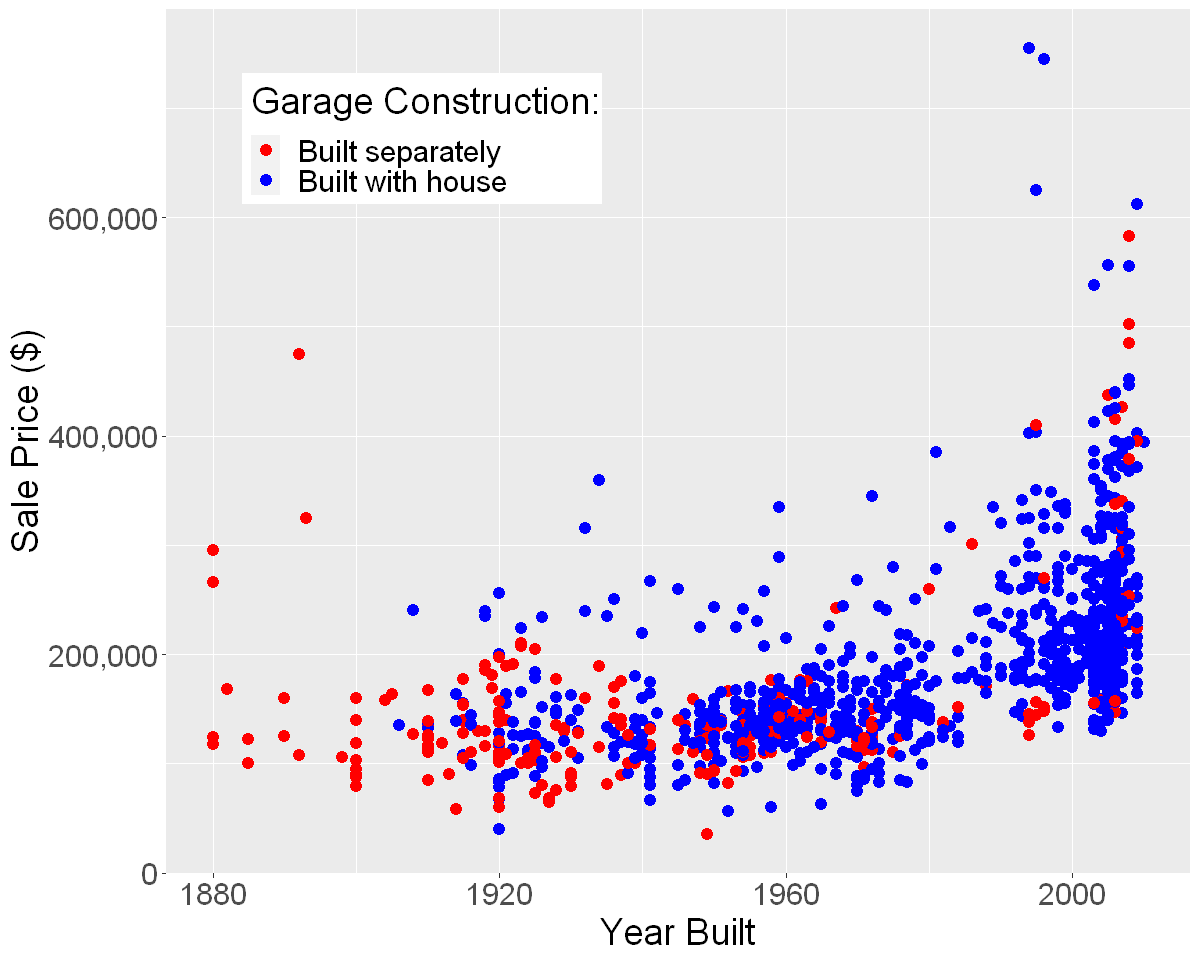

In [23]:
# Repurpose scatterplot function again specifically for this
plot_year_scatter <- function(data) {
    options(repr.plot.width = 10, repr.plot.height = 8)
    ggplot(data = data) +
      geom_point(aes(x = YearBuilt, y = SalePrice, color = ifelse(data['YearBuilt'] == data['GarageYrBlt'], 'Built with house', 'Built separately')), size = 3) +
      scale_y_continuous(label = label_comma()) +
      labs(x = axis_label('YearBuilt'), y = axis_label('SalePrice'), color = 'Garage Construction:') +
      scale_colour_manual(values=c("red","blue")) +
      theme(axis.title = element_text(size = 22),
            axis.text = element_text(size = 18),
            legend.position = c(0.25, 0.85),
            legend.title = element_text(size = 22),
            legend.text = element_text(size = 18),
            legend.direction = 'vertical')
}
plot_year_scatter(train_sct_trim %>% drop_na('GarageYrBlt'))

It does not appear whether the garage was constructed with the house or not impacts the sale price. This may be a feature to ignore and simply use the year of construction for the house.

Decks, porches, and pools could potentially add value to the sale price. Let's see how the areas of these features impacts sale price.

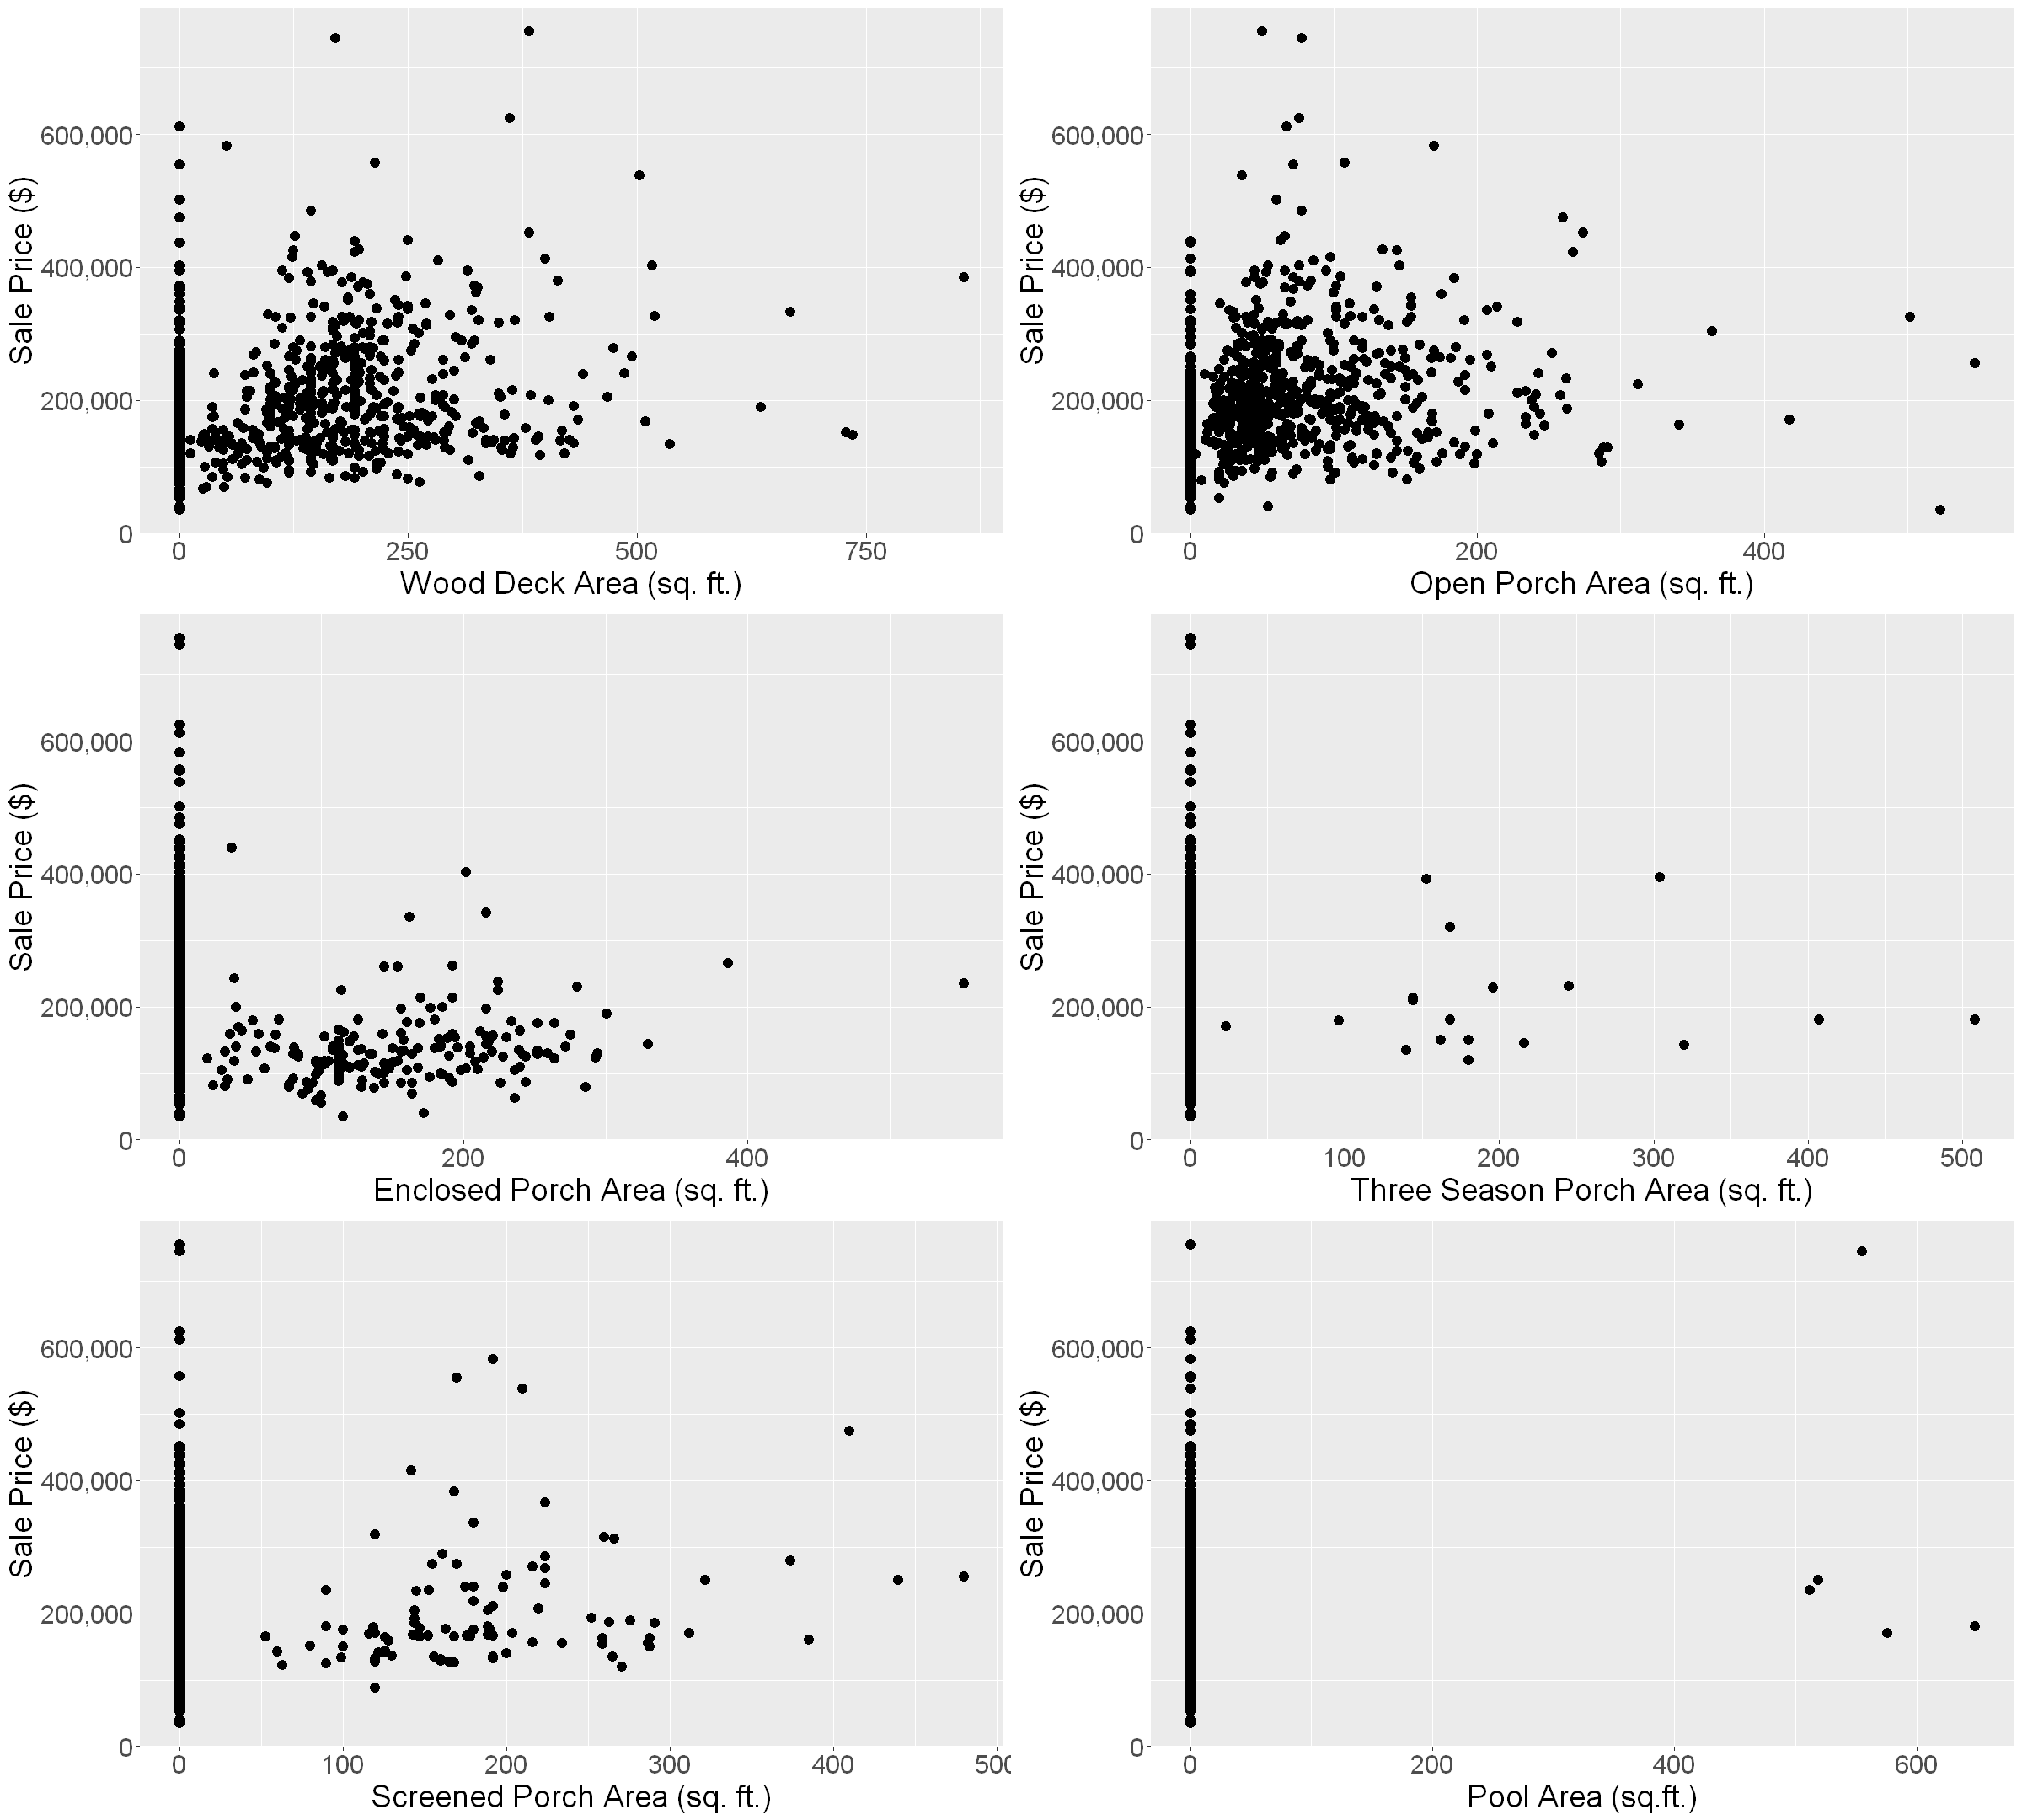

In [24]:
deck_porch_pool <- c('WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea')
scatter_plots(train_sct_trim, deck_porch_pool)

These plots are rather informative.

First, it is apparenty that almost none of the house sold have a pool. This is not that suprising considering the homes are located in Iowa, which is in the northern half of the United States. Therefore, any features related to pools can be ignored for model construction.

Deck and porch areas do not appear to have clear impact on sale price and may be worth excluding during model construction.

This concludes the exploratory analysis of the continuous variables. Now it is time to look at the categorical (and pseudo-categorical) variables, and how they may impact sale price (continued in Part 3).